# Imports

In [341]:
%reload_ext autoreload
import os
import pandas as pd
import numpy as np
import anndata
import time
import json
import matplotlib.pyplot as plt
import requests
import seaborn as sns
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
import matplotlib.colors as plt_colors
from allensdk.core.reference_space_cache import ReferenceSpaceCache
from pathlib import Path
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors
from Utils.Settings import output_folder_calculations, order_division, order_broad_division, class_to_division, class_to_broad_division, htr_families, neuron_cluster_groups_order, manifest, download_base
from Utils.Utils import broad_division_color_map, htr_cmap_rgb, cluster_groups_cmap, htr_cmap
import matplotlib.colors as mcolors


# Load data

In [2]:
metadata = manifest['file_listing']['WMB-10X']['metadata']

In [3]:
rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath )
cell = pd.read_csv(file, keep_default_na=False)
cell.set_index('cell_label',inplace=True)

In [4]:
matrices = cell.groupby(['dataset_label','feature_matrix_label'])[['library_label']].count()
matrices.columns  = ['cell_count']


In [5]:
rpath = metadata['example_genes_all_cells_expression']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
exp = pd.read_csv(file)
exp.set_index('cell_label',inplace=True)
exp = exp.sort_index(axis=1)


# Process

In [834]:
def percentage_non_zero(series):
    return (series != 0).sum() / len(series) * 100


In [6]:
cell["division"] = cell['class'].map(class_to_division)
cell["broad_division"] = cell['class'].map(class_to_broad_division)

In [7]:
metadata = manifest['file_listing']['WMB-neighborhoods']['metadata']
rpath = metadata['cluster_group_membership']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath)
group_membership = pd.read_csv(file) # cluster can belong to two different groups


In [8]:
cell_with_membership = cell.reset_index().merge(group_membership[["cluster_group_label", "cluster_alias", "cluster_group_name"]], on='cluster_alias').set_index("cell_label")


In [9]:
cell_with_membership["cluster_group_color"] = cell_with_membership["cluster_group_name"].map(cluster_groups_cmap)
cell['broad_division_color'] = cell['broad_division'].map(broad_division_color_map)

In [875]:
htrgenes = exp.columns.sort_values()

joined = cell.join(exp)
joined_boolean =  cell.join( exp.astype("bool") )
subsampled = joined.loc[::30]

In [11]:
joined_with_membership = cell_with_membership.join(exp)
joined_boolean_with_membership =  cell_with_membership.join( exp.astype("bool") )
subsampled_with_membership = joined_with_membership.loc[::30]

In [12]:
thr = exp[exp>0].quantile(.9)
joined_boolean_top_10 = cell.join( exp > thr)

In [13]:
neurotransmitter_color_map = {}
for n in cell['neurotransmitter'].unique():
    neurotransmitter_color_map[n] = cell[cell['neurotransmitter'] == n]['neurotransmitter_color'][0]

In [ ]:
classification_cmap = joined.drop_duplicates(subset='subclass').set_index('subclass')['subclass_color'].to_dict()
classification_cmap.update(joined.drop_duplicates(subset='supertype').set_index('supertype')['subclass_color'].to_dict())
classification_cmap.update(joined.drop_duplicates(subset='cluster').set_index('cluster')['subclass_color'].to_dict())
classification_cmap.update(joined.drop_duplicates(subset='class').set_index('class')['class_color'].to_dict())


## Co-exp

In [850]:
coexp = {}
for gene_target in tqdm(htrgenes):
    for gene_to_check in htrgenes: 
        coexp[gene_target, gene_to_check] = joined_boolean[[gene_target, gene_to_check]].all(axis=1).sum()/(joined_boolean[gene_target]>0).sum()

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
coloc = pd.DataFrame.from_dict(coexp, orient='index', columns=['Value'])
coloc[['Gene1', 'Gene2']] = pd.DataFrame(coloc.index.tolist(), index=coloc.index)
coloc = coloc.reset_index(drop=True)

# Reorder the columns for clarity
coloc = coloc[['Gene1', 'Gene2', 'Value']]
coloc["Value"] = coloc["Value"] * 100

In [ ]:
coloc

In [848]:
coloc

Gene1  Gene2       Value
154  Htr5b  Htr1a   20.732544
155  Htr5b  Htr1b   24.599249
156  Htr5b  Htr1d    3.227670
157  Htr5b  Htr1f   43.515777
158  Htr5b  Htr2a   31.572677
159  Htr5b  Htr2b    3.294462
160  Htr5b  Htr2c   41.021012
161  Htr5b  Htr3a    0.895372
162  Htr5b  Htr3b    0.117337
163  Htr5b   Htr4   38.760921
164  Htr5b  Htr5a   20.716297
165  Htr5b  Htr5b  100.000000
166  Htr5b   Htr6    3.399162
167  Htr5b   Htr7   24.323056

In [632]:
coloc.to_pickle(f"{output_folder_calculations}/total_colocalization.pkl")

In [ ]:
coexp = {}
for division in tqdm(joined_boolean["broad_division"].unique()):
    for gene_target in htrgenes:
        for gene_to_check in tqdm(htrgenes): 
            coexp[gene_target, gene_to_check, division] = joined_boolean[joined_boolean["broad_division"]==division][[gene_target, gene_to_check]].all(axis=1).sum()/(joined_boolean[joined_boolean["broad_division"]==division][gene_target]>0).sum()


In [ ]:
coloc = pd.DataFrame.from_dict(coexp, orient='index', columns=['Value'])
coloc[['Gene1', 'Gene2', "broad_division"]] = pd.DataFrame(coloc.index.tolist(), index=coloc.index)
coloc = coloc.reset_index(drop=True)

# Reorder the columns for clarity
coloc = coloc[["broad_division",'Gene1', 'Gene2', 'Value']]


In [ ]:
output_folder_calculations

In [ ]:
coloc.to_pickle(f"{output_folder_calculations}/broad_division_colocalization.pkl")

In [ ]:
coexp = {}
for division in tqdm(joined_boolean["division"].unique()):
    for gene_target in htrgenes:
        for gene_to_check in tqdm(htrgenes): 
            coexp[gene_target, gene_to_check, division] = joined_boolean[joined_boolean["division"]==division][[gene_target, gene_to_check]].all(axis=1).sum()/(joined_boolean[joined_boolean["division"]==division][gene_target]>0).sum()


In [ ]:
coloc = pd.DataFrame.from_dict(coexp, orient='index', columns=['Value'])
coloc[['Gene1', 'Gene2', "Division"]] = pd.DataFrame(coloc.index.tolist(), index=coloc.index)
coloc = coloc.reset_index(drop=True)

# Reorder the columns for clarity
coloc = coloc[["Division",'Gene1', 'Gene2', 'Value']]


In [ ]:
coloc.to_pickle(f"{output_folder_calculations}/colocalization.pkl")

In [ ]:
coexp = {}
for division in tqdm([x for x in neuron_cluster_groups_order if x != "WholeBrain"]):
    for gene_target in htrgenes:
        for gene_to_check in tqdm(htrgenes): 
            coexp[gene_target, gene_to_check, division] = joined_boolean_with_membership[joined_boolean_with_membership["cluster_group_name"]==division][[gene_target, gene_to_check]].all(axis=1).sum()/(joined_boolean_with_membership[joined_boolean_with_membership["cluster_group_name"]==division][gene_target]>0).sum()


In [71]:
coloc = pd.DataFrame.from_dict(coexp, orient='index', columns=['Value'])
coloc[['Gene1', 'Gene2', "group"]] = pd.DataFrame(coloc.index.tolist(), index=coloc.index)
coloc = coloc.reset_index(drop=True)

# Reorder the columns for clarity
coloc = coloc[["group",'Gene1', 'Gene2', 'Value']]


In [72]:
coloc.to_pickle(f"{output_folder_calculations}/cluster_group_colocalization.pkl")

# Expression Htr 

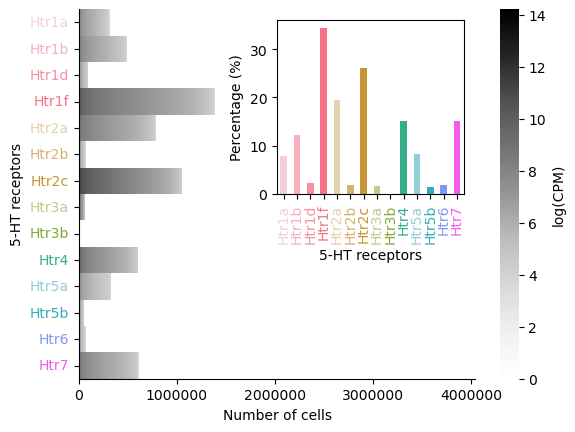

In [14]:
def expr_htrs_whole_brain(ax_, exp):
    sns.heatmap(pd.DataFrame(np.sort(exp.values, axis=0)[::-200], columns=exp.columns, 
                                  index=exp.reset_index().index[::200]).T, xticklabels=5000, cbar_kws={'label': 'log(CPM)'}, cmap="Greys", ax=ax)
    ax.set_xlabel("Number of cells")
    ax.set_ylabel("5-HT receptors")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    colors_list = [htr_cmap_rgb[receptor] for receptor in exp.columns]
    
    for ytick in ax.get_yticklabels():
        ytick.set_color(htr_cmap_rgb[ytick.get_text()])
    
    axins = ax.inset_axes( [0.5, 0.5, 0.47, 0.47])
    ((exp.astype("bool").sum(axis=0)/exp.shape[0])*100).plot.bar(ax=axins, color=colors_list)
    axins.set_xlabel("5-HT receptors")
    axins.set_ylabel("Percentage (%)")
    
    for xtick in axins.get_xticklabels():
        xtick.set_color(htr_cmap_rgb[xtick.get_text()])

fig, ax = plt.subplots()
expr_htrs_whole_brain(ax, exp)

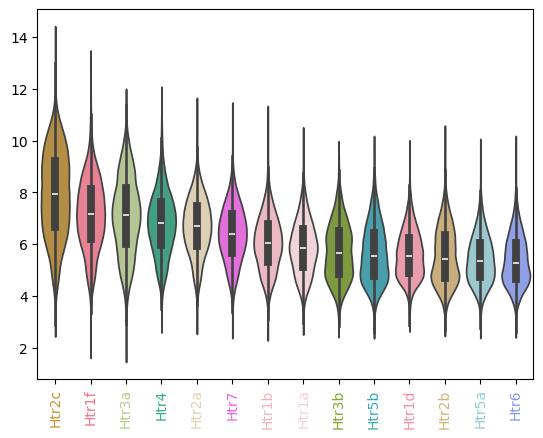

In [25]:
ax = sns.violinplot(exp[exp>0].loc[:,exp[exp>0].mean().sort_values(ascending=False).index], palette=htr_cmap_rgb)
plt.draw()
for xtick in ax.get_xticklabels():
    xtick.set_color(htr_cmap_rgb[xtick.get_text()])
    xtick.set_rotation(90)

In [26]:
joined_any_htr =  cell.join(exp.any(axis=1).rename("htr"))

donor_counts = cell['donor_label'].value_counts()
#valid_donors = donor_counts[donor_counts > 1000].index

#joined_any_htr = joined_any_htr[joined_any_htr['donor_label'].isin(valid_donors)]

In [35]:
ax = sns.barplot(data=(joined_any_htr.groupby(["broad_division", 'donor_label'])["htr"].sum()/joined_any_htr.groupby(["broad_division", 'donor_label'])["htr"].size()).reset_index() , y="htr",  x="broad_division", hue="broad_division", palette= broad_division_color_map, order=order_broad_division, legend=False )

ax.set_yticklabels(['{:.0f}%'.format(y*100) for y in ax.get_yticks()])
plt.ylabel('Percentage expressing any htr (%)')

/tmp/ipykernel_3175583/2021622824.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(y*100) for y in ax.get_yticks()])


Text(0, 0.5, 'Percentage expressing any htr (%)')

In [28]:
joined_any_htr =  cell_with_membership.join(exp.any(axis=1).rename("htr"))

donor_counts = cell['donor_label'].value_counts()
#valid_donors = donor_counts[donor_counts > 1000].index

#joined_any_htr = joined_any_htr[joined_any_htr['donor_label'].isin(valid_donors)]

/tmp/ipykernel_3175583/177689356.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=(joined_any_htr.groupby(["cluster_group_name", 'donor_label'])["htr"].sum()/joined_any_htr.groupby(["cluster_group_name", 'donor_label'])["htr"].size()).reset_index(), y="htr", x="cluster_group_name", palette=cluster_groups_cmap, order = neuron_cluster_groups_order)
/tmp/ipykernel_3175583/177689356.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(y*100) for y in ax.get_yticks()])


Text(0, 0.5, 'Percentage expressing any htr (%)')

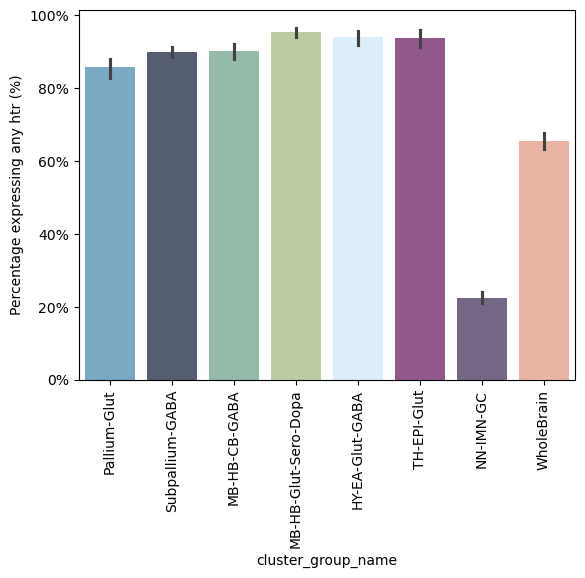

In [29]:
ax = sns.barplot(data=(joined_any_htr.groupby(["cluster_group_name", 'donor_label'])["htr"].sum()/joined_any_htr.groupby(["cluster_group_name", 'donor_label'])["htr"].size()).reset_index(), y="htr", x="cluster_group_name", palette=cluster_groups_cmap, order = neuron_cluster_groups_order)

for label in ax.get_xticklabels():
    label.set_rotation(90)

ax.set_yticklabels(['{:.0f}%'.format(y*100) for y in ax.get_yticks()])
plt.ylabel('Percentage expressing any htr (%)')

## Difference between Htr1 and htr2 UMAP distribtion

In [36]:
def diff_htr1_htr2_umap(axs):
    _ = subsampled.dropna()
    
    legend_handles = []
    
    # Create a Patch (a colored box) for each name and color, and add it to legend_handles
    for name in order_broad_division:
        
        legend_handles.append(mpatches.Patch(color=broad_division_color_map[name], label=name))
    
    axs[0].legend(handles=legend_handles, title='Broad Division', ncol=int(np.ceil(len(legend_handles)/2)), loc='upper left', bbox_to_anchor=(0, 1.12),
             handlelength=.5, handletextpad=0.1, borderaxespad=0, framealpha=.2)
    
    axs[0].scatter(_['x'], _['y'], c=_["broad_division_color"], s=0.5, marker='.')
    axs[0].axis('off')
    
    for gene in htr_families["Htr1"]:
       axs[1].scatter(_['x'], _['y'], c=_[gene], s=0.5, marker='.', cmap="Reds")
    axs[1].axis('off')
    axs[1].set_title('Htr1 family')
    
    for gene in htr_families["Htr2"]:  
       axs[2].scatter(_['x'], _['y'], c=_[gene], s=0.5, marker='.', cmap='YlOrBr')
    
    axs[2].axis('off')
    axs[2].set_title('Htr2 family')


In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
diff_htr1_htr2_umap(axs)

In [37]:
def diff_htr1_htr2_umap_ABC_groups(axs):
    _ = subsampled_with_membership[subsampled_with_membership["cluster_group_name"]!="WholeBrain"].dropna()
    
    legend_handles = []
    
    # Create a Patch (a colored box) for each name and color, and add it to legend_handles
    for name in [x for x in neuron_cluster_groups_order if x != "WholeBrain"]:
        legend_handles.append(mpatches.Patch(color=cluster_groups_cmap[name], label=name))
    
    axs.legend(handles=legend_handles, title='Groups', ncol=int(np.ceil(len(legend_handles)/2)), loc='upper left', bbox_to_anchor=(0, 1.12),
             handlelength=.5, handletextpad=0.1, borderaxespad=0, framealpha=.2)
    
    axs.scatter(_['x'], _['y'], c=_["cluster_group_color"], s=0.5, marker='.')
    axs.axis('off')


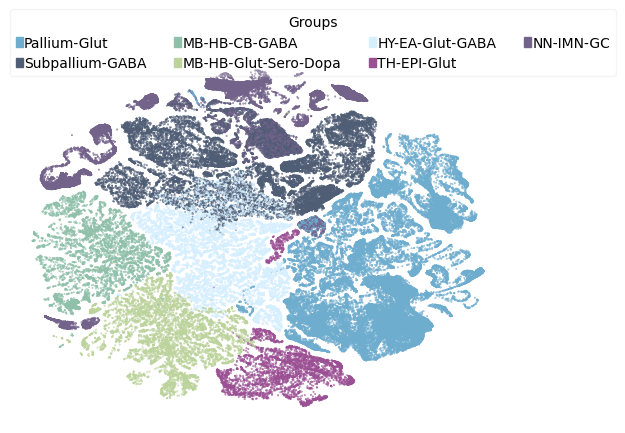

In [38]:
fig, axs = plt.subplots()
diff_htr1_htr2_umap_ABC_groups(axs)

## UMAP 5-HT receptors vs neurotransmitter, class, region

In [ ]:
k = len(htrgenes) + 6

# Calculate number of rows for the grid
ncols = 3
nrows = int(np.ceil(k / ncols))

# Create a figure with the desired overall width and height
fig, axs = plt.subplots(nrows,ncols,figsize=(25,45))

for n, item in enumerate(["neurotransmitter", "class"]):      
    _ = subsampled[[item, item + "_color"]].drop_duplicates()
    _ = _.sort_values(item)
    # Create custom legend elements
    legend_elements = [mpatches.Patch(color=row[item + '_color'], label=row[item]) for x, row in _.iterrows()]
    axs[0,n].legend(handles=legend_elements, ncol=3, loc="center")

_ = subsampled[["region_of_interest_acronym", "region_of_interest_color"]].drop_duplicates()
_ = _.sort_values("region_of_interest_acronym")
# Create custom legend elements
legend_elements = [mpatches.Patch(color=row["region_of_interest_color"], label=row["region_of_interest_acronym"]) for x, row in _.iterrows()]
axs[0,2].legend(handles=legend_elements, ncol=3, loc="center")

axs[1,0].scatter(subsampled['x'], subsampled['y'], c=subsampled['neurotransmitter_color'], s=0.5, marker='.')
axs[1,0].set_title("Neurotransmitter") 
axs[1,2].scatter(subsampled['x'], subsampled['y'], c=subsampled['region_of_interest_color'], s=0.5, marker='.')
axs[1,2].set_title("Region") 
axs[1,1].scatter(subsampled['x'], subsampled['y'], c=subsampled['class_color'], s=0.5, marker='.')
axs[1,1].set_title("Class") 

for n, gene in enumerate(htrgenes):
    row = n // ncols
    col = n % ncols
    sc = axs[row + 2, col ].scatter(subsampled['x'], subsampled['y'], c=subsampled[gene], s=0.5, marker='.', cmap=plt.cm.magma_r)
    axs[row + 2, col].set_title(gene) 

for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')

plt.tight_layout()

## expression htr grouped by neurotransmitter

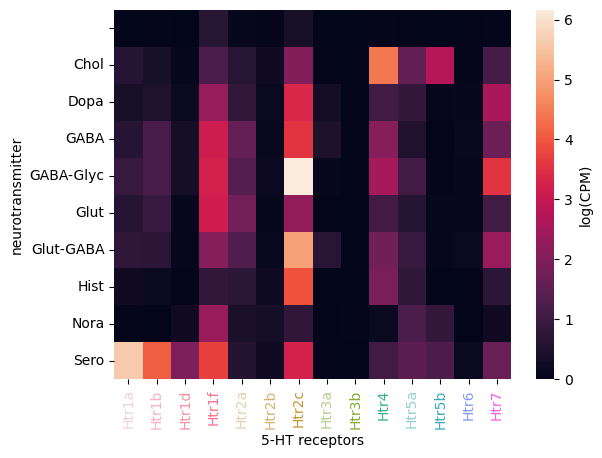

In [841]:
ax = sns.heatmap(joined.groupby("neurotransmitter")[htrgenes].mean(), yticklabels=True, cbar_kws={'label': 'log(CPM)'}, cmap="rocket")
ax.set_xlabel("5-HT receptors")
for ytick in ax.get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

plt.draw()

In [842]:
ax = sns.heatmap(joined.groupby("neurotransmitter")[htrgenes].apply(percentage_non_zero), yticklabels=True, cbar_kws={'label': 'log(CPM)'}, cmap="rocket")
ax.set_xlabel("5-HT receptors")
for ytick in ax.get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

plt.draw()

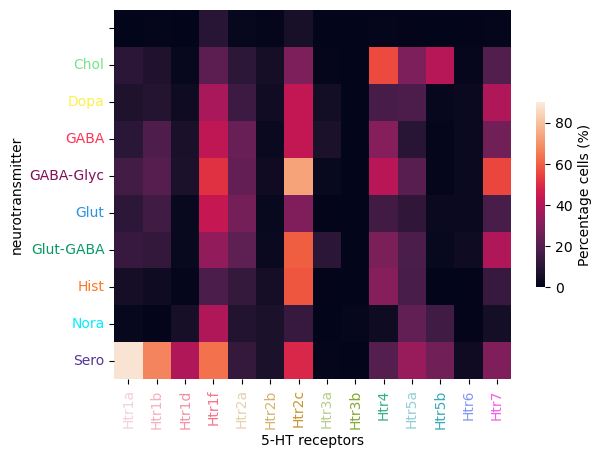

In [844]:
def expr_htrs_by_neurotransmitter(ax):
    sns.heatmap(joined.groupby("neurotransmitter")[htrgenes].apply(percentage_non_zero),
            yticklabels=True, cbar_kws={'label': 'Percentage cells (%)', "shrink": 0.5}, cmap="rocket", ax=ax,vmax=90)
    ax.set_xlabel("5-HT receptors")
    for ytick in ax.get_xticklabels():
        ytick.set_color(htr_cmap_rgb[ytick.get_text()])
    for ytick in ax.get_yticklabels():
        ytick.set_color(neurotransmitter_color_map[ytick.get_text()])

fig, ax = plt.subplots()
expr_htrs_by_neurotransmitter(ax)

## expression across regions 

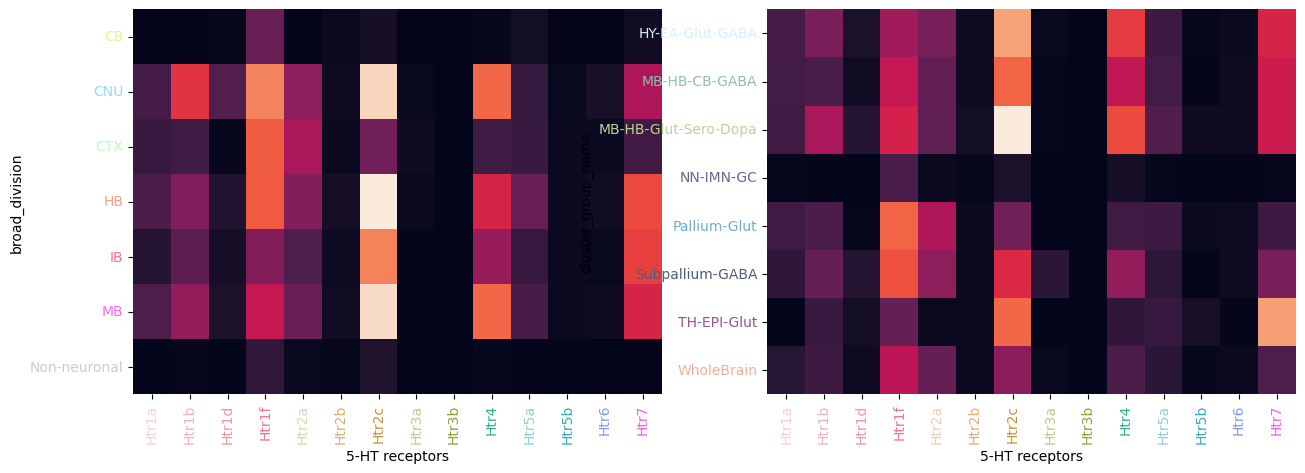

In [846]:
def expr_htrs_by_area(axs):
    sns.heatmap(joined.groupby("broad_division")[htrgenes].apply(percentage_non_zero),
                yticklabels=True, cbar_kws={'label': 'Percentage cells (%)', "shrink": 0.5}, ax=axs[0], cbar=False )
    axs[0].set_xlabel("5-HT receptors")
    for ytick in axs[0].get_xticklabels():
        ytick.set_color(htr_cmap_rgb[ytick.get_text()])
    for ytick in axs[0].get_yticklabels():
        ytick.set_color( broad_division_color_map[ytick.get_text()])
    
    sns.heatmap(joined_with_membership.groupby("cluster_group_name")[htrgenes].apply(percentage_non_zero),
                yticklabels=True, cbar_kws={'label': 'Percentage cells (%)', "shrink": 0.5}, ax=axs[1], cbar=False )
    axs[1].set_xlabel("5-HT receptors")
    for ytick in axs[1].get_xticklabels():
        ytick.set_color(htr_cmap_rgb[ytick.get_text()])
    for ytick in axs[1].get_yticklabels():
        ytick.set_color(cluster_groups_cmap[ytick.get_text()])

fig, axs = plt.subplots(1,2, figsize=(15,5))
expr_htrs_by_area(axs)

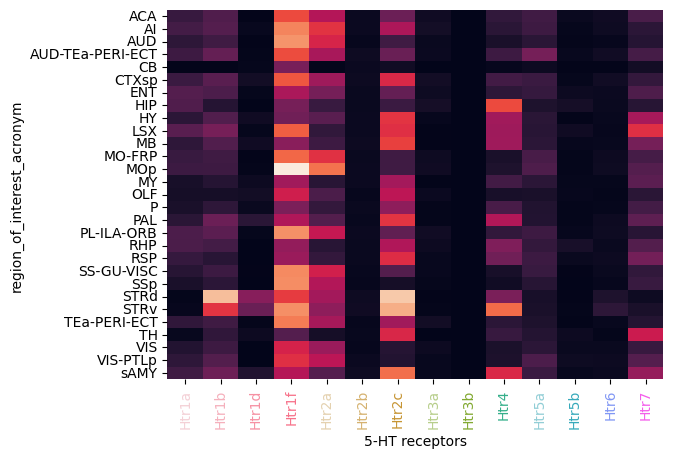

In [847]:
ax = sns.heatmap(joined.groupby("region_of_interest_acronym")[htrgenes].apply(percentage_non_zero),
            yticklabels=True,cbar_kws={'label': 'Percentage cells (%)', "shrink": 0.5}, cbar=False )
ax.set_xlabel("5-HT receptors")
for ytick in ax.get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])




## expression across classes

In [566]:
def expr_htrs_by_classes(ax): 
    sns.heatmap(joined.groupby("class")[htrgenes].apply(percentage_non_zero),
                yticklabels=True, cbar_kws={'label': 'Percentage cells (%)', "shrink": 0.5}, ax=ax, cbar=False )
    ax.set_xlabel("5-HT receptors")
    for ytick in ax.get_xticklabels():
        ytick.set_color(htr_cmap_rgb[ytick.get_text()])
    for ytick in ax.get_yticklabels():
        ytick.set_color(classification_cmap[ytick.get_text()])

fig, ax = plt.subplots()
expr_htrs_by_classes(ax)

# Correlation

In [86]:
def corr_htrs(ax): 
    _ = exp.corr()
    sns.heatmap(_[_<1],  ax=ax, cbar_kws={'label': 'Pearson correlation', "shrink": 0.5})
    for ytick in ax.get_xticklabels():
        ytick.set_color(htr_cmap_rgb[ytick.get_text()])
    for ytick in ax.get_yticklabels():
        ytick.set_color(htr_cmap_rgb[ytick.get_text()])
    ax.set_xlabel("5-HT receptors")
    ax.set_ylabel("5-HT receptors")
fig, ax = plt.subplots()
corr_htrs(ax)

In [88]:
# Create 4x2 subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for i, area in enumerate(order_broad_division):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    subset = joined[joined["broad_division"] == area]
    correlation = subset[htrgenes].corr()
    sns.heatmap(correlation[correlation < 1], ax=ax,vmin=-.2, vmax=.6,center=0, cbar_kws={'label': 'Pearson correlation', "shrink": 0.5}, cmap="vlag")
    ax.set_title(f"Correlation for {area}")

fig.delaxes(axes[3, 1])
plt.tight_layout()

0it [00:00, ?it/s]

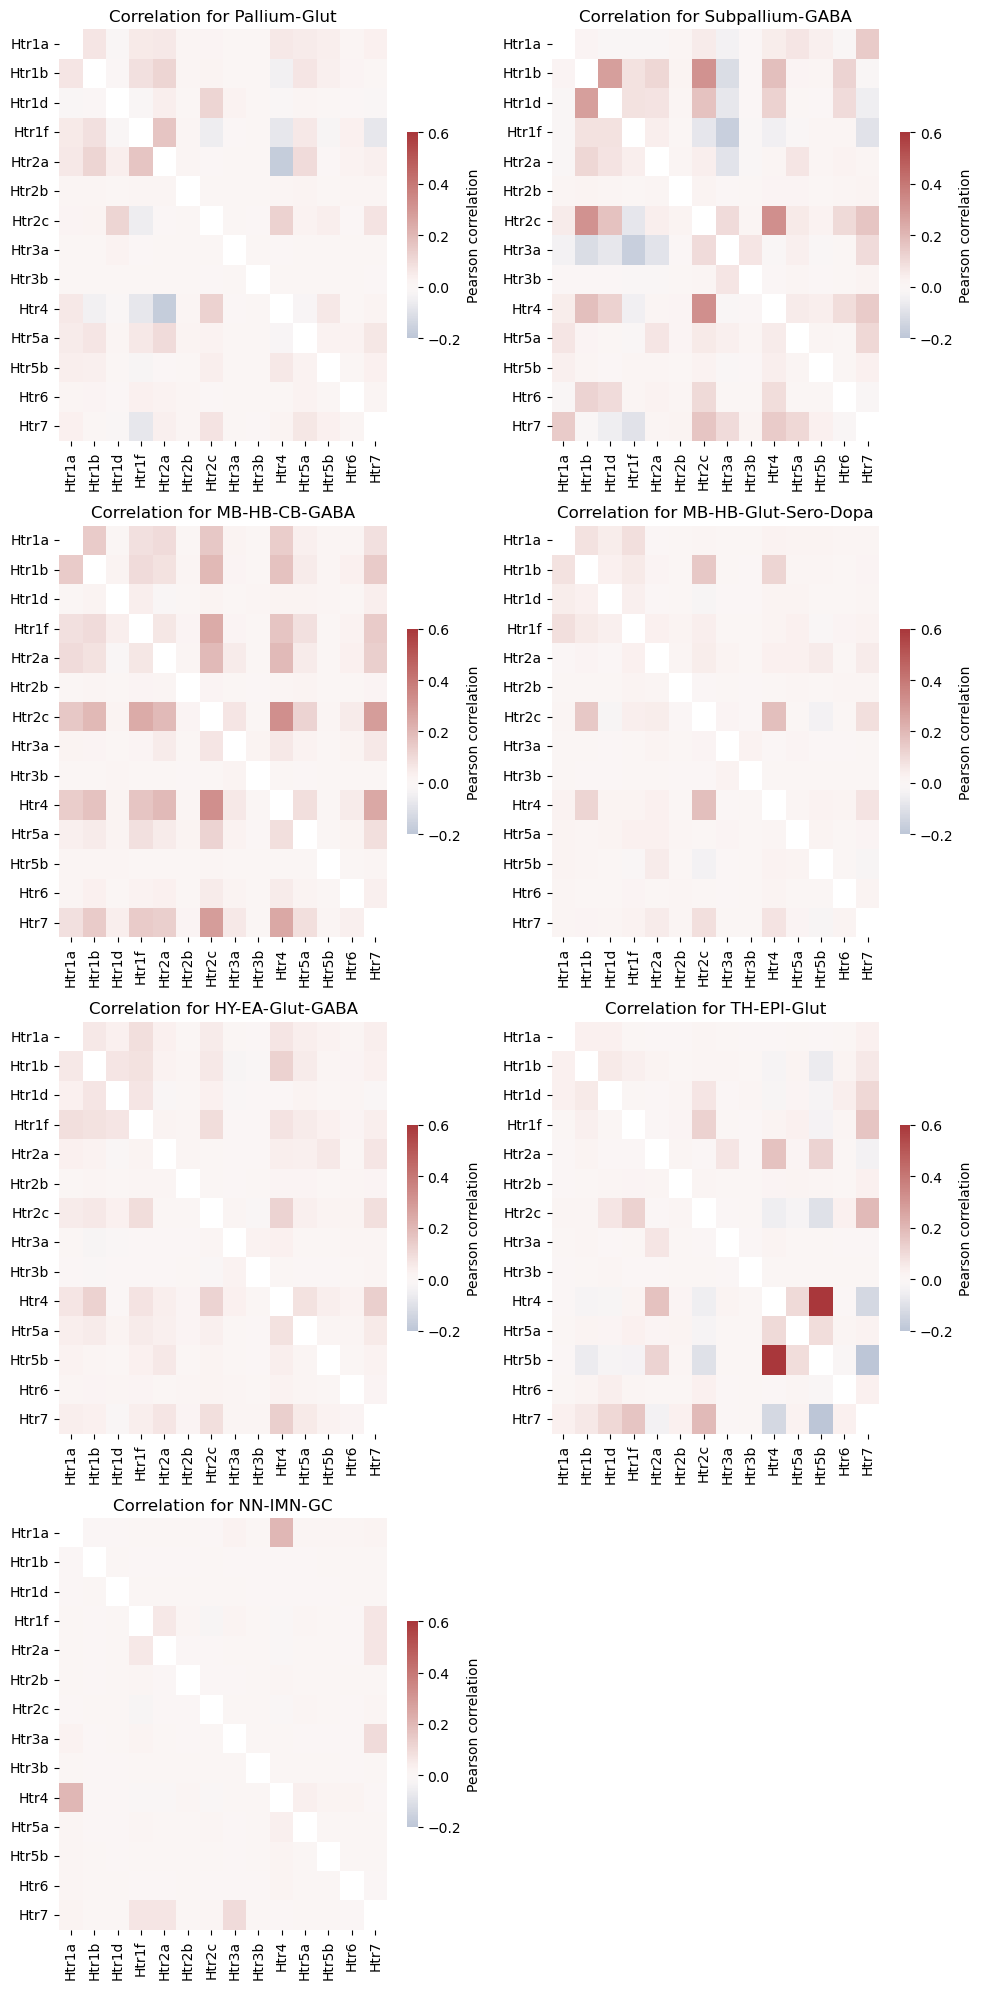

In [89]:
# Create 4x2 subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for i, area in tqdm(enumerate([x for x in neuron_cluster_groups_order if x != "WholeBrain"])):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    subset = joined_with_membership[joined_with_membership["cluster_group_name"] == area]
    correlation = subset[htrgenes].corr()
    sns.heatmap(correlation[correlation < 1], ax=ax, vmin=-.2, vmax=.6,center=0, cbar_kws={'label': 'Pearson correlation', "shrink": 0.5},  cmap="vlag")
    ax.set_title(f"Correlation for {area}")

fig.delaxes(axes[3, 1])
plt.tight_layout()

# Co-expression

## Percentage colocalize in whole brain

In [642]:
coloc = pd.read_pickle(f"{output_folder_calculations}/total_colocalization.pkl")

## how many cells expressing any htr express also the receptor on the xaxis?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


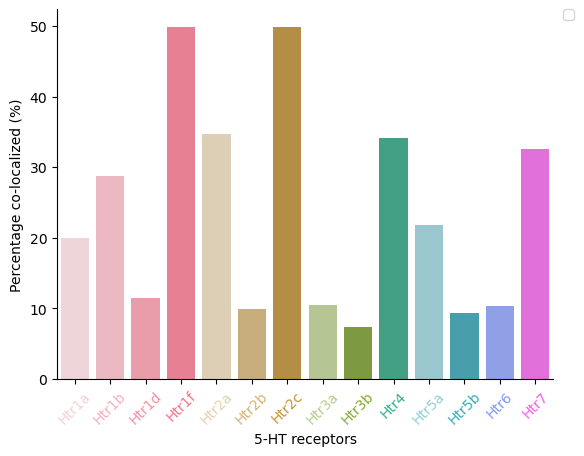

In [643]:
ax = sns.barplot(data=coloc.groupby( "Gene2")["Value"].mean().reset_index(), x="Gene2", hue="Gene2", y="Value", palette=htr_cmap)
plt.draw()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel("5-HT receptors")
ax.set_ylabel("Percentage co-localized (%)")
ax.tick_params(axis='x', rotation=45)
for ytick in ax.get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])
sns.despine()

## how many cells expressing htr in xaxis express also another receptor?

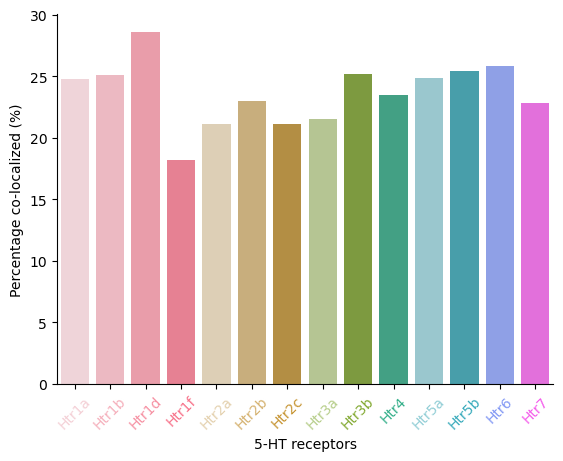

In [644]:
def plot_coloc(ax):
    sns.barplot(data=coloc.groupby( "Gene1")["Value"].mean().reset_index(), x="Gene1", hue="Gene1", y="Value", palette=htr_cmap, ax=ax)
    ax.set_xlabel("5-HT receptors")
    ax.set_ylabel("Percentage co-localized (%)")
    ax.tick_params(axis='x', rotation=45)
    plt.draw()
    for ytick in ax.get_xticklabels():
        ytick.set_color(htr_cmap_rgb[ytick.get_text()])

    sns.despine()
fig, ax = plt.subplots()
plot_coloc(ax)

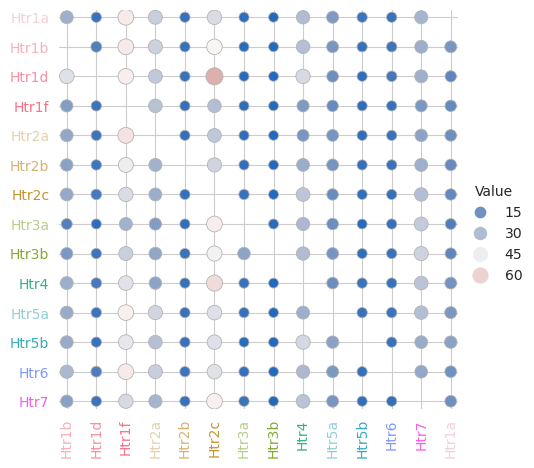

In [646]:
def scatterheat_coloc():
    coloc = pd.read_pickle(f"{output_folder_calculations}/total_colocalization.pkl")
    with sns.axes_style("whitegrid"):
        g = sns.relplot(
            data=coloc[coloc["Value"]<100],
            y="Gene1", x="Gene2", hue="Value", size="Value",
            palette="vlag", hue_norm=(0, 100), edgecolor=".7",
            height=5, sizes=(50, 150), size_norm=(coloc[coloc["Value"]<100]["Value"].min(), coloc[coloc["Value"]<100]["Value"].max()),
        )
        g.set(xlabel="", ylabel="", aspect="equal")
        g.despine(left=True, bottom=True)
        g.ax.margins(.02)
        for label in g.ax.get_xticklabels():
            label.set_rotation(90)

        for ax in g.axes.flat:  # Loop through the individual axes
            for label in ax.get_xticklabels():
                # Your code to modify the x-tick labels goes here
                label.set_color(htr_cmap_rgb[label.get_text()])
            for label in ax.get_yticklabels():
                # Your code to modify the x-tick labels goes here
                label.set_color(htr_cmap_rgb[label.get_text()])
    #plt.close()
    return g
g = scatterheat_coloc()

In [ ]:
g.savefig("fvvvsfvsfvsdv")

## Coexpression by division

In [ ]:
coloc = pd.read_pickle(f"{output_folder_calculations}/broad_division_colocalization.pkl")

fig, axs = plt.subplots(1,2, figsize=(10,5))
# Create the line plot
sns.barplot(
    data=coloc.groupby(["broad_division", "Gene1"])["Value"].mean().reset_index(),
    hue="Gene1", y="Value", x="broad_division",  palette=htr_cmap, ax=axs[1], order = order_broad_division
)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
axs[1].set_xlabel("Division")
axs[1].set_ylabel("Percentage co-localized (%)")

axs[1].tick_params(axis='x', rotation=45)

sns.barplot(
    data=coloc.groupby(["broad_division", "Gene1"])["Value"].mean().reset_index(),
    y="Value", x="broad_division",hue="broad_division", palette=broad_division_color_map, ax=axs[0], order = order_broad_division
)

axs[0].set_xlabel("Division")
axs[0].set_ylabel("Percentage co-localized (%)")

axs[0].tick_params(axis='x', rotation=45)


In [649]:
def coloc_by_broad_division(ax):

    coloc = pd.read_pickle(f"{output_folder_calculations}/broad_division_colocalization.pkl")

    sns.barplot(
    data=coloc.groupby(["broad_division", "Gene1"])["Value"].mean().reset_index(),
    y="Value", x="broad_division",hue="broad_division", palette=broad_division_color_map, ax=ax, order = order_broad_division
)

    ax.set_xlabel("Division")
    ax.set_ylabel("Percentage co-localized (%)")
    
    ax.tick_params(axis='x', rotation=45)
    sns.despine()

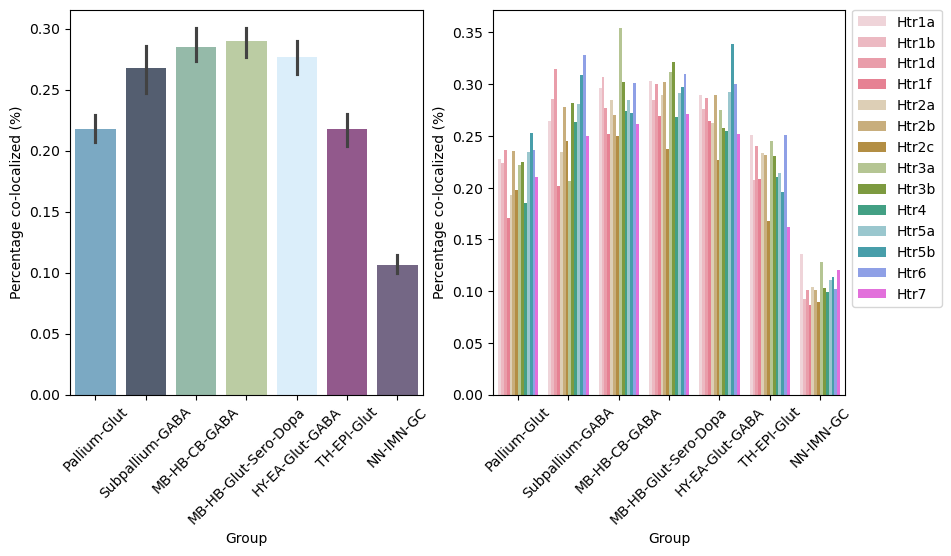

In [656]:
coloc = pd.read_pickle(f"{output_folder_calculations}/cluster_group_colocalization.pkl")

fig, axs = plt.subplots(1,2, figsize=(10,5))
# Create the line plot
sns.barplot(
    data=coloc.groupby(["group", "Gene1"])["Value"].mean().reset_index(),
    hue="Gene1", y="Value", x="group", palette=htr_cmap, ax=axs[1], order = [x for x in neuron_cluster_groups_order if x != "WholeBrain"]
)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
axs[1].set_xlabel("Group")
axs[1].set_ylabel("Percentage co-localized (%)")

axs[1].tick_params(axis='x', rotation=45)

sns.barplot(
    data=coloc.groupby(["group", "Gene1"])["Value"].mean().reset_index(),
    y="Value", x="group",hue="group", palette=cluster_groups_cmap, ax=axs[0], order = [x for x in neuron_cluster_groups_order if x != "WholeBrain"]
)

axs[0].set_xlabel("Group")
axs[0].set_ylabel("Percentage co-localized (%)")

axs[0].tick_params(axis='x', rotation=45)


### how many of the cells expressing the receptor on x axis express another 5-HT receptor

In [688]:
coloc = pd.read_pickle(f"{output_folder_calculations}/broad_division_colocalization.pkl")



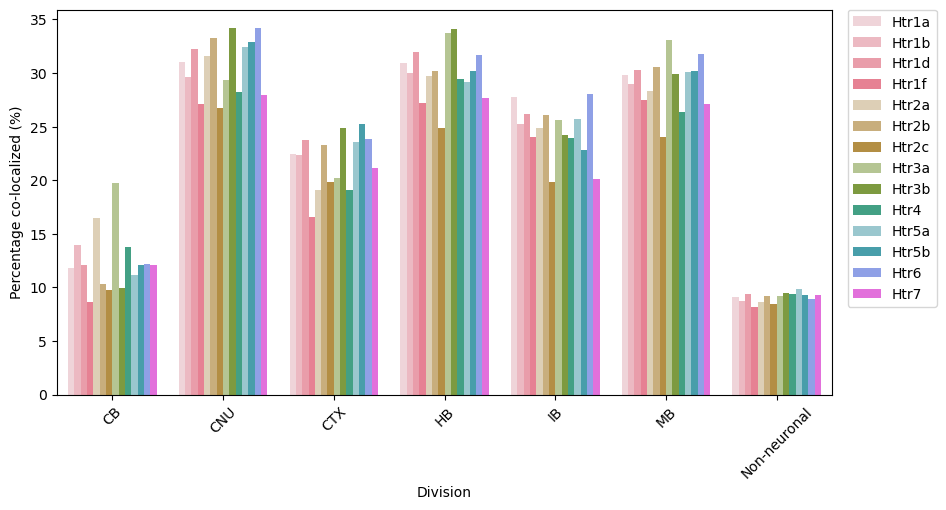

In [689]:
fig, ax = plt.subplots(figsize=(10,5))
# Create the line plot
ax = sns.barplot(
    data=coloc.groupby(["broad_division", "Gene1"])["Value"].mean().reset_index(),
    hue="Gene1", y="Value", x="broad_division", palette=htr_cmap
)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_xlabel("Division")
ax.set_ylabel("Percentage co-localized (%)")

ax.tick_params(axis='x', rotation=45)



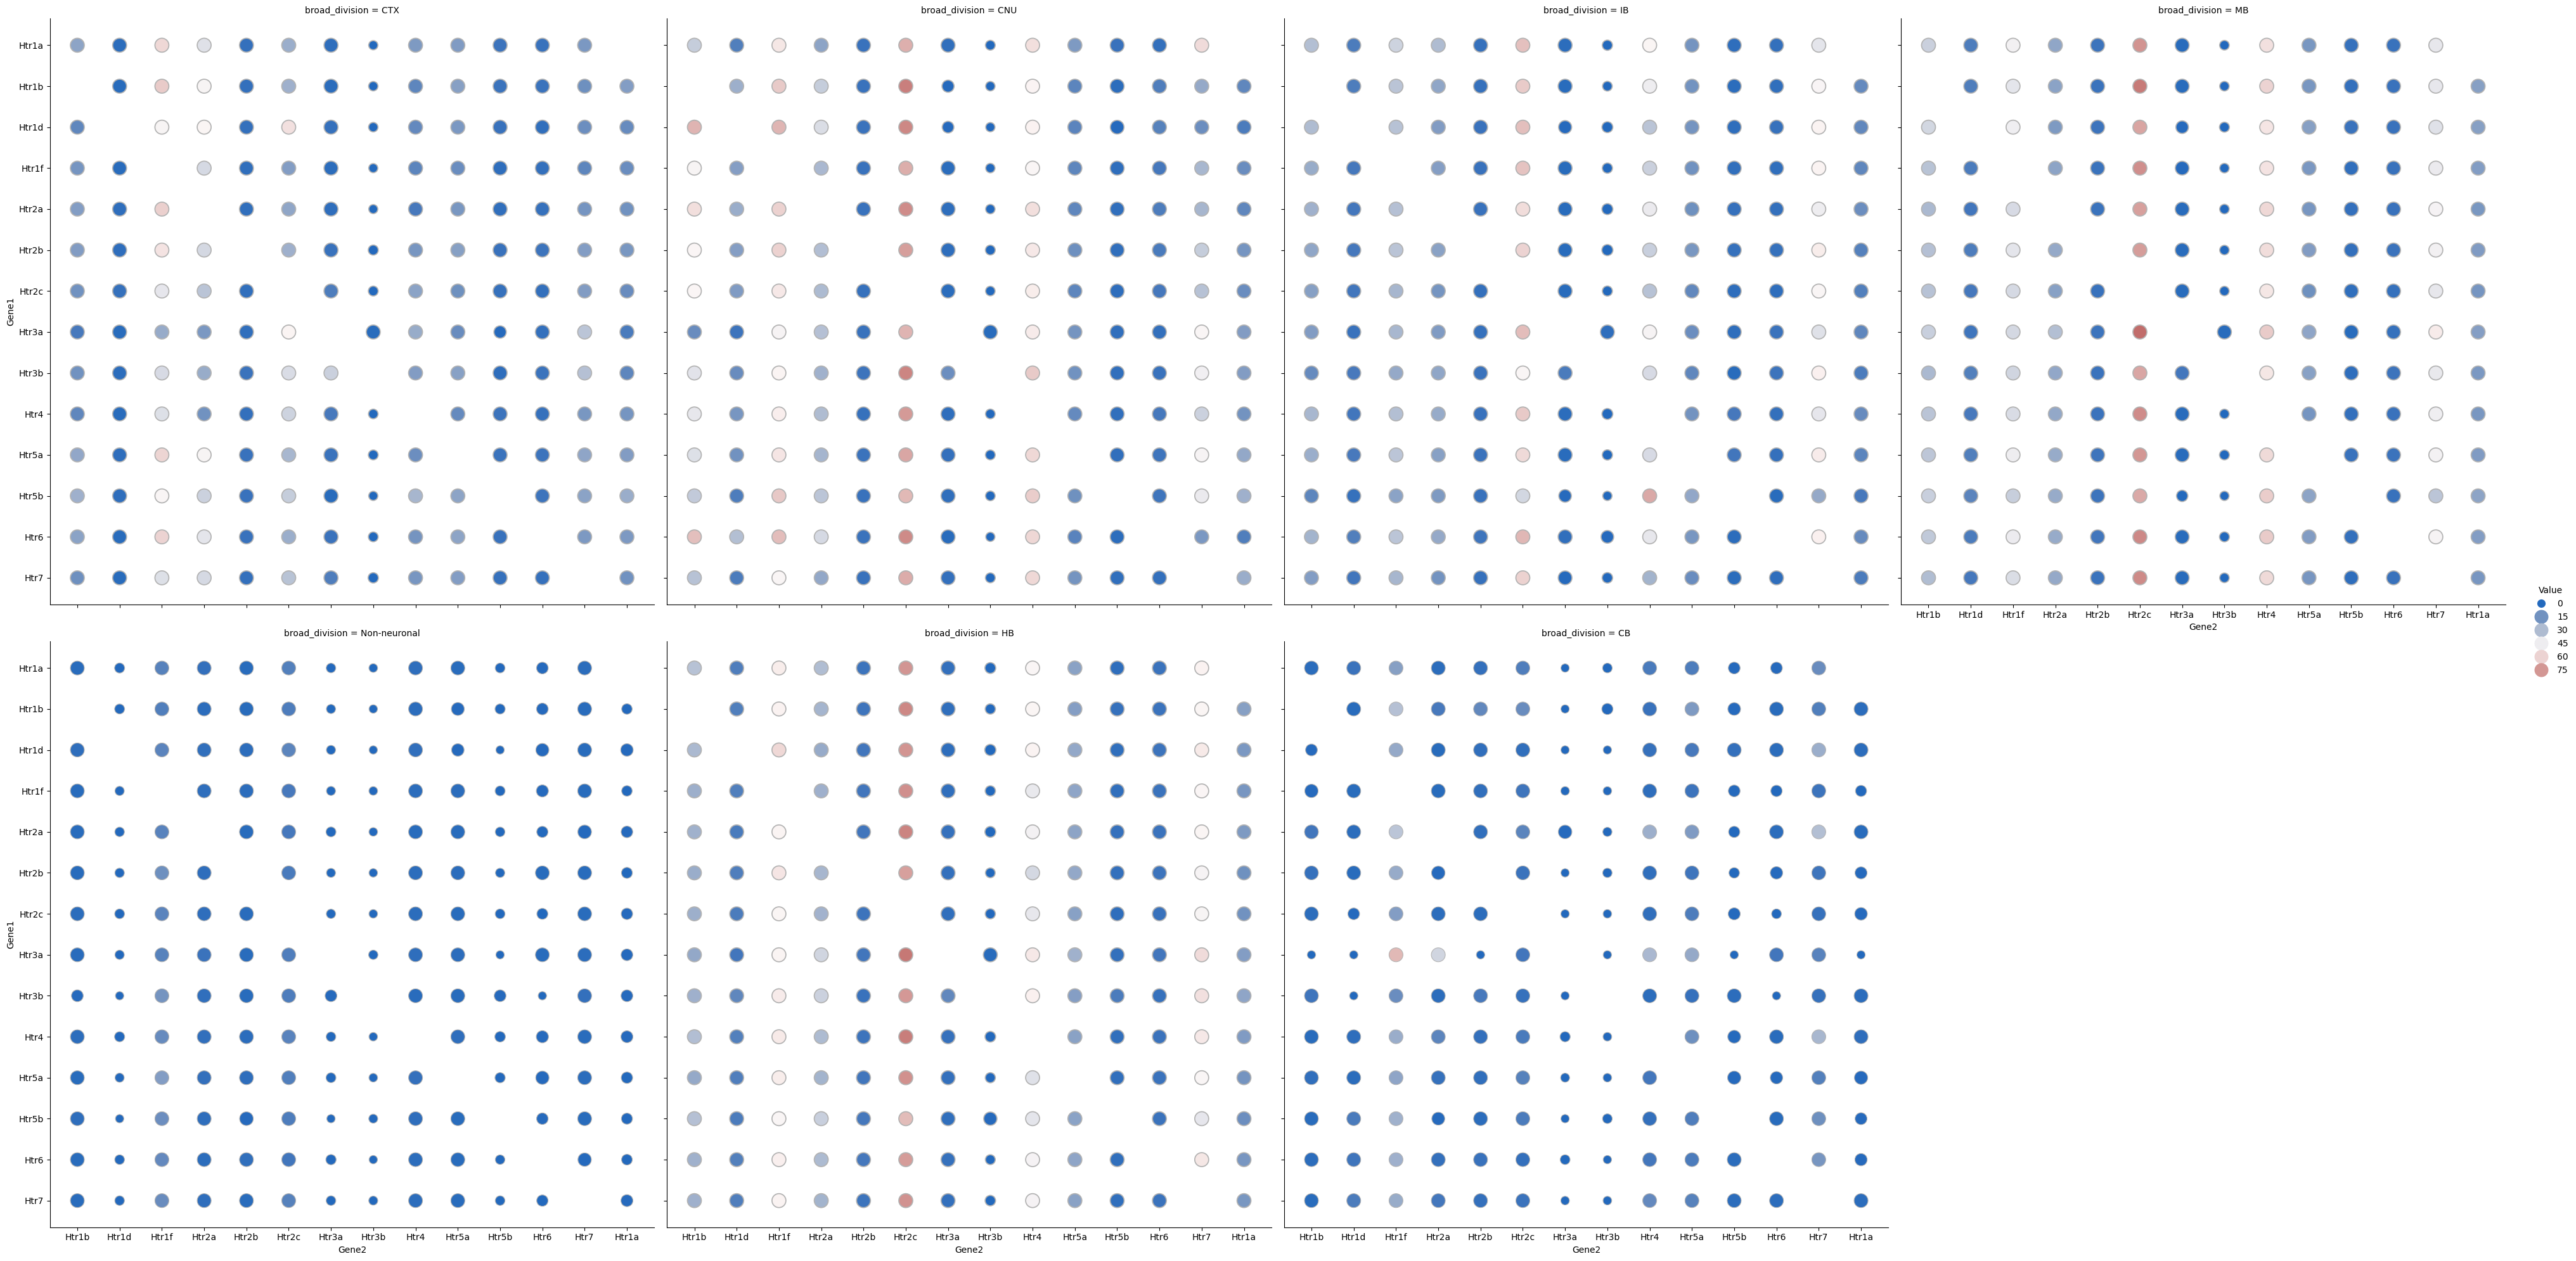

In [690]:
rg = sns.relplot(
    data=coloc[coloc["Value"]<100],
    y="Gene1", x="Gene2", hue="Value", size="Value",
    palette="vlag", hue_norm=(0, 100), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8), col= "broad_division", col_wrap=4
)
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)




# Figure 1

In [96]:
fig = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(3, 4, height_ratios=[1, 2.3, 1])

subfig = fig.add_subfigure(gs[0,0])
ax = subfig.subplots()
subfig.suptitle("A", x=-.0, y=1, fontsize=16, fontweight='bold');
subfig.subplots_adjust(wspace=0,left=0.1, bottom=.15, top=.96, right=1)
expr_htrs_whole_brain(ax, exp)

subfig = fig.add_subfigure(gs[0,1:])
axs = subfig.subplots(1,3)
subfig.suptitle("B", x=0, y=1, fontsize=16, fontweight='bold');
subfig.subplots_adjust(wspace=0.25, left=0.02, bottom=0, top=.95, right=1)
diff_htr1_htr2_umap(axs)

subfig = fig.add_subfigure(gs[1,0])
ax = subfig.subplots()
subfig.suptitle("C", x=-.0, y=1, fontsize=16, fontweight='bold');
subfig.subplots_adjust(wspace=0,  left=0.1, bottom=.1, top=.98)
expr_htrs_by_neurotransmitter(ax)

subfig = fig.add_subfigure(gs[1,1:3])
axs = subfig.subplots(1,2)
subfig.suptitle("D", x=0, y=1, fontsize=16, fontweight='bold');
subfig.subplots_adjust(wspace=.4, left=0.1, bottom=.1, top=.98, right=.95)
expr_htrs_by_area(axs)
axs[0].yaxis.set_label_coords(-0.1, 0.5) 
axs[1].yaxis.set_label_coords(-0.25, 0.5) 

subfig = fig.add_subfigure(gs[1,3])
axs = subfig.subplots()
subfig.suptitle("E", x=0, y=1, fontsize=16, fontweight='bold');
subfig.subplots_adjust(wspace=0.5, left=0.3, bottom=.1, top=.98, right=1)
expr_htrs_by_classes(axs)
axs.yaxis.set_label_coords(-0.25, 0.5) 

subfig = fig.add_subfigure(gs[2,0])
ax = subfig.subplots()
subfig.suptitle("F", x=-.0, y=1, fontsize=16, fontweight='bold');
subfig.subplots_adjust(wspace=0,  left=0.1, bottom=.1, top=.95)
corr_htrs(ax)

subfig = fig.add_subfigure(gs[2,1])
ax = subfig.subplots()
subfig.suptitle("G", x=0, y=1, fontsize=16, fontweight='bold');
subfig.subplots_adjust(wspace=0,  left=0.15, bottom=.1, top=.95)
plot_coloc(ax)

subfig = fig.add_subfigure(gs[2,2])
ax = subfig.subplots()
subfig.suptitle("H", x=0, y=1, fontsize=16, fontweight='bold');
subfig.subplots_adjust(wspace=0,  left=-.1, bottom=-.1, top=.99, right=1.1)
g = scatterheat_coloc()
g.savefig(f"{output_folder_calculations}/scatterheat.png")
img = plt.imread(f"{output_folder_calculations}/scatterheat.png")
ax.imshow(img) 
ax.axis('off')

subfig = fig.add_subfigure(gs[2,3])
ax = subfig.subplots()
subfig.suptitle("I", x=-.1, y=1, fontsize=16, fontweight='bold');
subfig.subplots_adjust(wspace=0,  left=0.1, bottom=.1, top=.95)
coloc_by_broad_division(ax)
ax.xaxis.set_label_coords(0.5, -.2) 

/tmp/ipykernel_3175583/1767626488.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


# CTX

In [854]:
group = "subclass"
area = "CTX"
sub_joined = joined[joined["broad_division"].isin([area])].sort_values(group)
sub_joined_boolean = joined_boolean[joined_boolean["broad_division"].isin([area])].sort_values(group)
sub_joined_boolean_top_10 = joined_boolean_top_10[joined_boolean_top_10["broad_division"].isin([area])].sort_values(group)

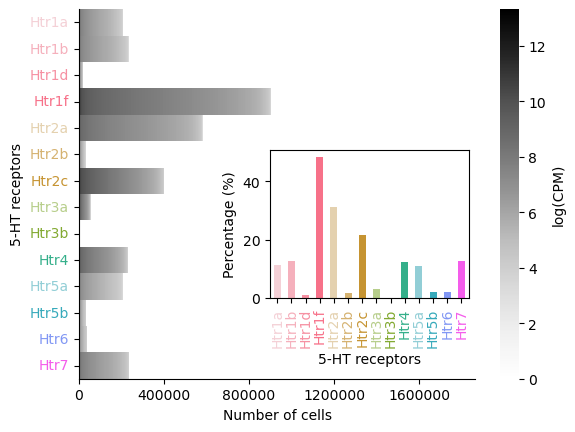

In [855]:
_ = sub_joined[htrgenes]
ax = sns.heatmap(pd.DataFrame(np.sort(_.values, axis=0)[::-200], columns=_.columns, 
                              index=_.reset_index().index[::200]).T, xticklabels=2000, cbar_kws={'label': 'log(CPM)'}, cmap="Greys")
ax.set_xlabel("Number of cells")
ax.set_ylabel("5-HT receptors")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

colors_list = [htr_cmap_rgb[receptor] for receptor in _.columns]

for ytick in ax.get_yticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

axins = inset_axes(ax, width="50%", height="40%", loc=4, bbox_to_anchor=(0, 0.2, 1, 1),  # (x, y, width, height) of the bounding box
    bbox_transform=ax.transAxes,  # coordinate system transformation
    )
((_.astype("bool").sum(axis=0)/_.shape[0])*100).plot.bar(ax=axins, color=colors_list)
axins.set_xlabel("5-HT receptors")
axins.set_ylabel("Percentage (%)")

for xtick in axins.get_xticklabels():
    xtick.set_color(htr_cmap_rgb[xtick.get_text()])

In [857]:
fig,axs = plt.subplots(1,2, figsize=(10,10))
sns.heatmap(sub_joined.groupby(group)[htrgenes].apply(percentage_non_zero),
            yticklabels=True, cbar_kws={'label': 'Percentage cells (%)'}, ax=axs[0])
axs[0].set_xlabel("5-HT receptors")
for ytick in axs[0].get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

sns.heatmap(sub_joined_boolean.groupby(group)[htrgenes].sum() ,
            yticklabels=False, cbar_kws={'label': 'Number cells expressing Htrs'}, ax=axs[1], vmax=100000)
axs[1].set_xlabel("5-HT receptors")
for ytick in axs[1].get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

for ytick in axs[0].get_yticklabels():
    ytick.set_color(sub_joined[sub_joined[group]==ytick.get_text()]['neurotransmitter_color'][0])


# CNU

In [ ]:
group = "subclass"
area = "CNU"
sub_joined = joined[joined["broad_division"].isin([area])].sort_values(group)
sub_joined_boolean = joined_boolean[joined_boolean["broad_division"].isin([area])].sort_values(group)
sub_joined_boolean_top_10 = joined_boolean_top_10[joined_boolean_top_10["broad_division"].isin([area])].sort_values(group)

In [ ]:
_ = sub_joined[htrgenes]
ax = sns.heatmap(pd.DataFrame(np.sort(_.values, axis=0)[::-200], columns=_.columns, 
                              index=_.reset_index().index[::200]).T, xticklabels=500, cbar_kws={'label': 'log(CPM)'}, cmap="Greys")
ax.set_xlabel("Number of cells")
ax.set_ylabel("5-HT receptors")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

colors_list = [htr_cmap_rgb[receptor] for receptor in _.columns]

for ytick in ax.get_yticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

axins = inset_axes(ax, width="50%", height="40%", loc=4, bbox_to_anchor=(0, 0.2, 1, 1),  # (x, y, width, height) of the bounding box
    bbox_transform=ax.transAxes,  # coordinate system transformation
    )
((_.astype("bool").sum(axis=0)/_.shape[0])*100).plot.bar(ax=axins, color=colors_list)
axins.set_xlabel("5-HT receptors")
axins.set_ylabel("Percentage (%)")
axins.patch.set_alpha(0.1)

for xtick, color in zip(axins.get_xticklabels(), colors_list):
    xtick.set_color(htr_cmap_rgb[xtick.get_text()])

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(10,10))
sns.heatmap(sub_joined.groupby(group)[htrgenes].apply(percentage_non_zero),
            yticklabels=True, cbar_kws={'label': 'Percentage cells (%)'}, ax=axs[0])
axs[0].set_xlabel("5-HT receptors")
for ytick in axs[0].get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

sns.heatmap(sub_joined_boolean.groupby(group)[htrgenes].sum() ,
            yticklabels=False, cbar_kws={'label': 'Number cells expressing Htrs'}, ax=axs[1])
axs[1].set_xlabel("5-HT receptors")
for ytick in axs[1].get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

for ytick in axs[0].get_yticklabels():
    ytick.set_color(sub_joined[sub_joined["subclass"]==ytick.get_text()]['neurotransmitter_color'][0])


# IB

In [ ]:
group = "subclass"
area = "IB"
sub_joined = joined[joined["broad_division"].isin([area])].sort_values(group)
sub_joined_boolean = joined_boolean[joined_boolean["broad_division"].isin([area])].sort_values(group)
sub_joined_boolean_top_10 = joined_boolean_top_10[joined_boolean_top_10["broad_division"].isin([area])].sort_values(group)

In [ ]:
_ = sub_joined[htrgenes]
ax = sns.heatmap(pd.DataFrame(np.sort(_.values, axis=0)[::-200], columns=_.columns, 
                              index=_.reset_index().index[::200]).T, xticklabels=500, cbar_kws={'label': 'log(CPM)'}, cmap="Greys")
ax.set_xlabel("Number of cells")
ax.set_ylabel("5-HT receptors")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

colors_list = [htr_cmap_rgb[receptor] for receptor in _.columns]

for ytick in ax.get_yticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

axins = inset_axes(ax, width="50%", height="40%", loc=4, bbox_to_anchor=(0, 0.2, 1, 1),  # (x, y, width, height) of the bounding box
    bbox_transform=ax.transAxes,  # coordinate system transformation
    )
((_.astype("bool").sum(axis=0)/_.shape[0])*100).plot.bar(ax=axins, color=colors_list)
axins.set_xlabel("5-HT receptors")
axins.set_ylabel("Percentage (%)")
axins.patch.set_alpha(0.1)
for xtick, color in zip(axins.get_xticklabels(), colors_list):
    xtick.set_color(htr_cmap_rgb[xtick.get_text()])

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(10,10))
sns.heatmap(sub_joined.groupby(group)[htrgenes].apply(percentage_non_zero),
            yticklabels=True, cbar_kws={'label': 'Percentage cells (%)'}, ax=axs[0])
axs[0].set_xlabel("5-HT receptors")
for ytick in axs[0].get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

sns.heatmap(sub_joined_boolean.groupby(group)[htrgenes].sum() ,
            yticklabels=False, cbar_kws={'label': 'Number cells expressing Htrs'}, ax=axs[1])
axs[1].set_xlabel("5-HT receptors")
for ytick in axs[1].get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

for ytick in axs[0].get_yticklabels():
    ytick.set_color(sub_joined[sub_joined["subclass"]==ytick.get_text()]['neurotransmitter_color'][0])


# MB

In [ ]:
group = "subclass"
sub_joined = joined[joined["broad_division"].isin(["MB"])].sort_values(group)
sub_joined_boolean = joined_boolean[joined_boolean["broad_division"].isin(["MB"])].sort_values(group)
sub_joined_boolean_top_10 = joined_boolean_top_10[joined_boolean_top_10["broad_division"].isin(["MB"])].sort_values(group)

In [ ]:
_ = sub_joined[htrgenes]
ax = sns.heatmap(pd.DataFrame(np.sort(_.values, axis=0)[::-200], columns=_.columns, 
                              index=_.reset_index().index[::200]).T, xticklabels=500, cbar_kws={'label': 'log(CPM)'}, cmap="Greys")
ax.set_xlabel("Number of cells")
ax.set_ylabel("5-HT receptors")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

colors_list = [htr_cmap_rgb[receptor] for receptor in _.columns]

for ytick in ax.get_yticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

axins = inset_axes(ax, width="50%", height="40%", loc=4, bbox_to_anchor=(0, 0.2, 1, 1),  # (x, y, width, height) of the bounding box
    bbox_transform=ax.transAxes,  # coordinate system transformation
    )
((_.astype("bool").sum(axis=0)/_.shape[0])*100).plot.bar(ax=axins, color=colors_list)
axins.set_xlabel("5-HT receptors")
axins.set_ylabel("Percentage (%)")
axins.patch.set_alpha(0.1)
for xtick, color in zip(axins.get_xticklabels(), colors_list):
    xtick.set_color(htr_cmap_rgb[xtick.get_text()])

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(10,10))
sns.heatmap(sub_joined.groupby(group)[htrgenes].apply(percentage_non_zero),
            yticklabels=True, cbar_kws={'label': 'Percentage cells (%)'}, ax=axs[0])
axs[0].set_xlabel("5-HT receptors")
for ytick in axs[0].get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

sns.heatmap(sub_joined_boolean.groupby(group)[htrgenes].sum() ,
            yticklabels=False, cbar_kws={'label': 'Number cells expressing Htrs'}, ax=axs[1])
axs[1].set_xlabel("5-HT receptors")
for ytick in axs[1].get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

for ytick in axs[0].get_yticklabels():
    ytick.set_color(sub_joined[sub_joined["subclass"]==ytick.get_text()]['neurotransmitter_color'][0])


# HB

In [ ]:
group = "subclass"
area = "HB"
sub_joined = joined[joined["broad_division"].isin([area])].sort_values(group)
sub_joined_boolean = joined_boolean[joined_boolean["broad_division"].isin([area])].sort_values(group)
sub_joined_boolean_top_10 = joined_boolean_top_10[joined_boolean_top_10["broad_division"].isin([area])].sort_values(group)

In [ ]:
_ = sub_joined[htrgenes]
ax = sns.heatmap(pd.DataFrame(np.sort(_.values, axis=0)[::-200], columns=_.columns, 
                              index=_.reset_index().index[::200]).T, xticklabels=500, cbar_kws={'label': 'log(CPM)'}, cmap="Greys")
ax.set_xlabel("Number of cells")
ax.set_ylabel("5-HT receptors")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

colors_list = [htr_cmap_rgb[receptor] for receptor in _.columns]

for ytick in ax.get_yticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

axins = inset_axes(ax, width="50%", height="40%", loc=4, bbox_to_anchor=(0, 0.2, 1, 1),  # (x, y, width, height) of the bounding box
    bbox_transform=ax.transAxes,  # coordinate system transformation
    )
((_.astype("bool").sum(axis=0)/_.shape[0])*100).plot.bar(ax=axins, color=colors_list)
axins.set_xlabel("5-HT receptors")
axins.set_ylabel("Percentage (%)")
axins.patch.set_alpha(0.1)
for xtick, color in zip(axins.get_xticklabels(), colors_list):
    xtick.set_color(htr_cmap_rgb[xtick.get_text()])

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(10,10))
sns.heatmap(sub_joined.groupby(group)[htrgenes].apply(percentage_non_zero),
            yticklabels=True, cbar_kws={'label': 'Percentage cells (%)'}, ax=axs[0])
axs[0].set_xlabel("5-HT receptors")
for ytick in axs[0].get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

sns.heatmap(sub_joined_boolean.groupby(group)[htrgenes].sum() ,
            yticklabels=False, cbar_kws={'label': 'Number cells expressing Htrs'}, ax=axs[1])
axs[1].set_xlabel("5-HT receptors")
for ytick in axs[1].get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

for ytick in axs[0].get_yticklabels():
    ytick.set_color(sub_joined[sub_joined["subclass"]==ytick.get_text()]['neurotransmitter_color'][0])


# CB

In [345]:
group = "subclass"
area = "CB"
sub_joined = joined[joined["broad_division"].isin([area])].sort_values(group)
sub_joined_boolean = joined_boolean[joined_boolean["broad_division"].isin([area])].sort_values(group)
sub_joined_boolean_top_10 = joined_boolean_top_10[joined_boolean_top_10["broad_division"].isin([area])].sort_values(group)

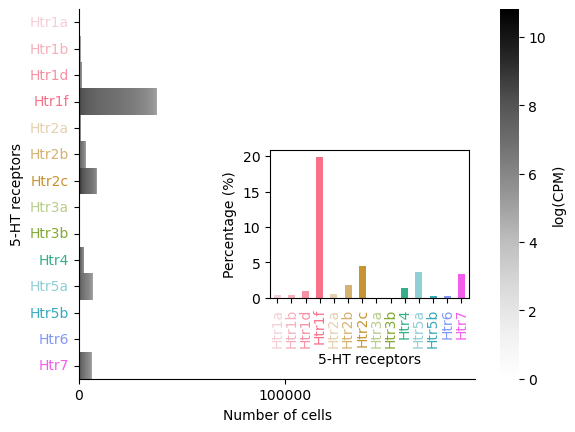

In [346]:
_ = sub_joined[htrgenes]
ax = sns.heatmap(pd.DataFrame(np.sort(_.values, axis=0)[::-200], columns=_.columns, 
                              index=_.reset_index().index[::200]).T, xticklabels=500, cbar_kws={'label': 'log(CPM)'}, cmap="Greys")
ax.set_xlabel("Number of cells")
ax.set_ylabel("5-HT receptors")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

colors_list = [htr_cmap_rgb[receptor] for receptor in _.columns]

for ytick in ax.get_yticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

axins = inset_axes(ax, width="50%", height="40%", loc=4, bbox_to_anchor=(0, 0.2, 1, 1),  # (x, y, width, height) of the bounding box
    bbox_transform=ax.transAxes,  # coordinate system transformation
    )
((_.astype("bool").sum(axis=0)/_.shape[0])*100).plot.bar(ax=axins, color=colors_list)
axins.set_xlabel("5-HT receptors")
axins.set_ylabel("Percentage (%)")
axins.patch.set_alpha(0.1)
for xtick in axins.get_xticklabels():
    xtick.set_color(htr_cmap_rgb[xtick.get_text()])

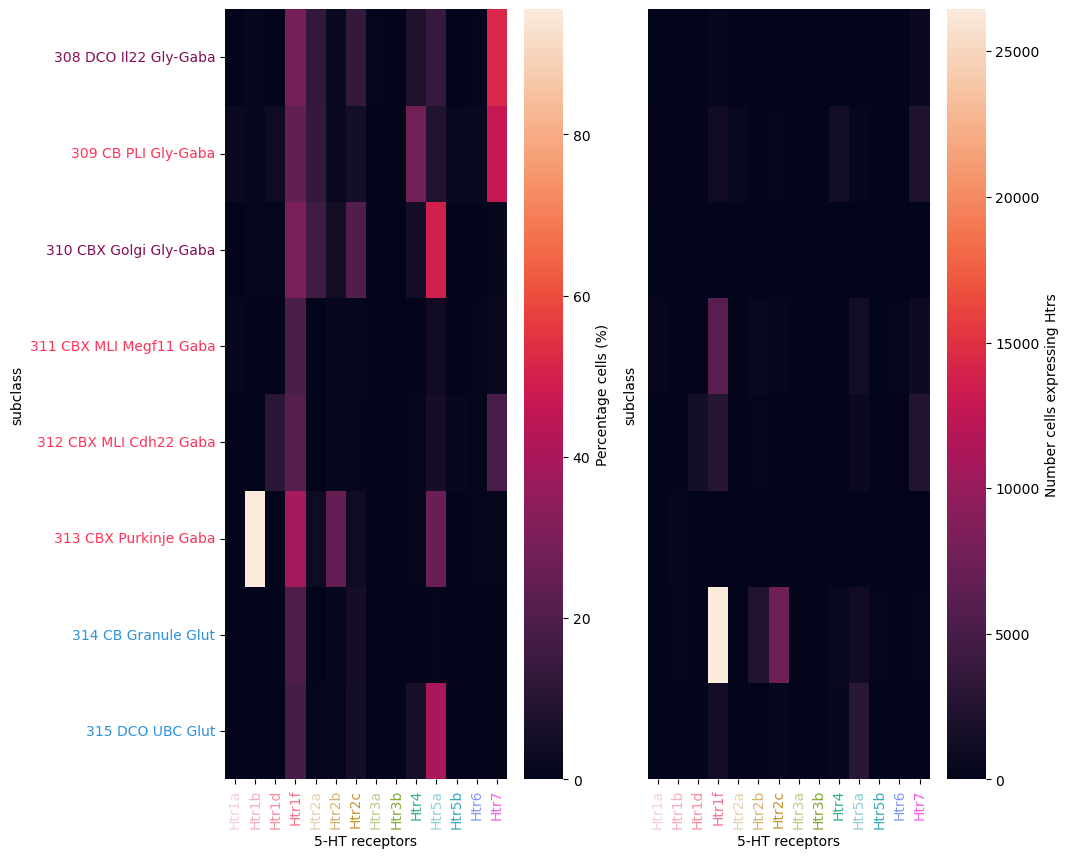

In [347]:
fig,axs = plt.subplots(1,2, figsize=(10,10))
sns.heatmap(sub_joined.groupby(group)[htrgenes].apply(percentage_non_zero),
            yticklabels=True, cbar_kws={'label': 'Percentage cells (%)'}, ax=axs[0])
axs[0].set_xlabel("5-HT receptors")
for ytick in axs[0].get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

sns.heatmap(sub_joined_boolean.groupby(group)[htrgenes].sum() ,
            yticklabels=False, cbar_kws={'label': 'Number cells expressing Htrs'}, ax=axs[1])
axs[1].set_xlabel("5-HT receptors")
for ytick in axs[1].get_xticklabels():
    ytick.set_color(htr_cmap_rgb[ytick.get_text()])

for ytick in axs[0].get_yticklabels():
    ytick.set_color(sub_joined[sub_joined["subclass"]==ytick.get_text()]['neurotransmitter_color'][0])


# Htr1a

In [860]:
gene = "Htr2a"
data = joined_with_membership.groupby(["cluster_group_name"])[gene].apply(percentage_non_zero).reset_index()
data = data[data["cluster_group_name"]!="WholeBrain"]


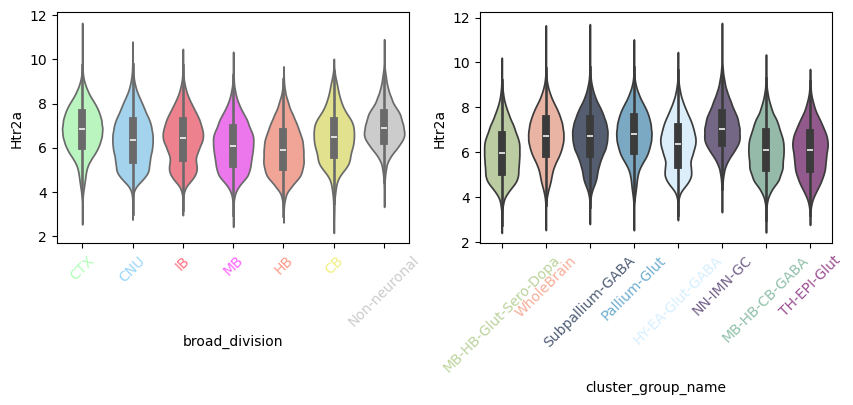

In [861]:
fig, axs = plt.subplots(1,2, figsize=(10,3))
sns.violinplot(data=joined_with_membership[joined_with_membership[gene]>0], y=gene,x="cluster_group_name",hue="cluster_group_name" ,ax=axs[1], palette=cluster_groups_cmap)
sns.violinplot(data=joined[joined[gene]>0], y=gene,x="broad_division", hue="broad_division",ax=axs[0], palette=broad_division_color_map)

for ax in axs:
    ax.tick_params(axis='x', rotation=45)
plt.draw()
for ytick in axs[0].get_xticklabels():
    ytick.set_color(broad_division_color_map[ytick.get_text()])

for ytick in axs[1].get_xticklabels():
    ytick.set_color(cluster_groups_cmap[ytick.get_text()])


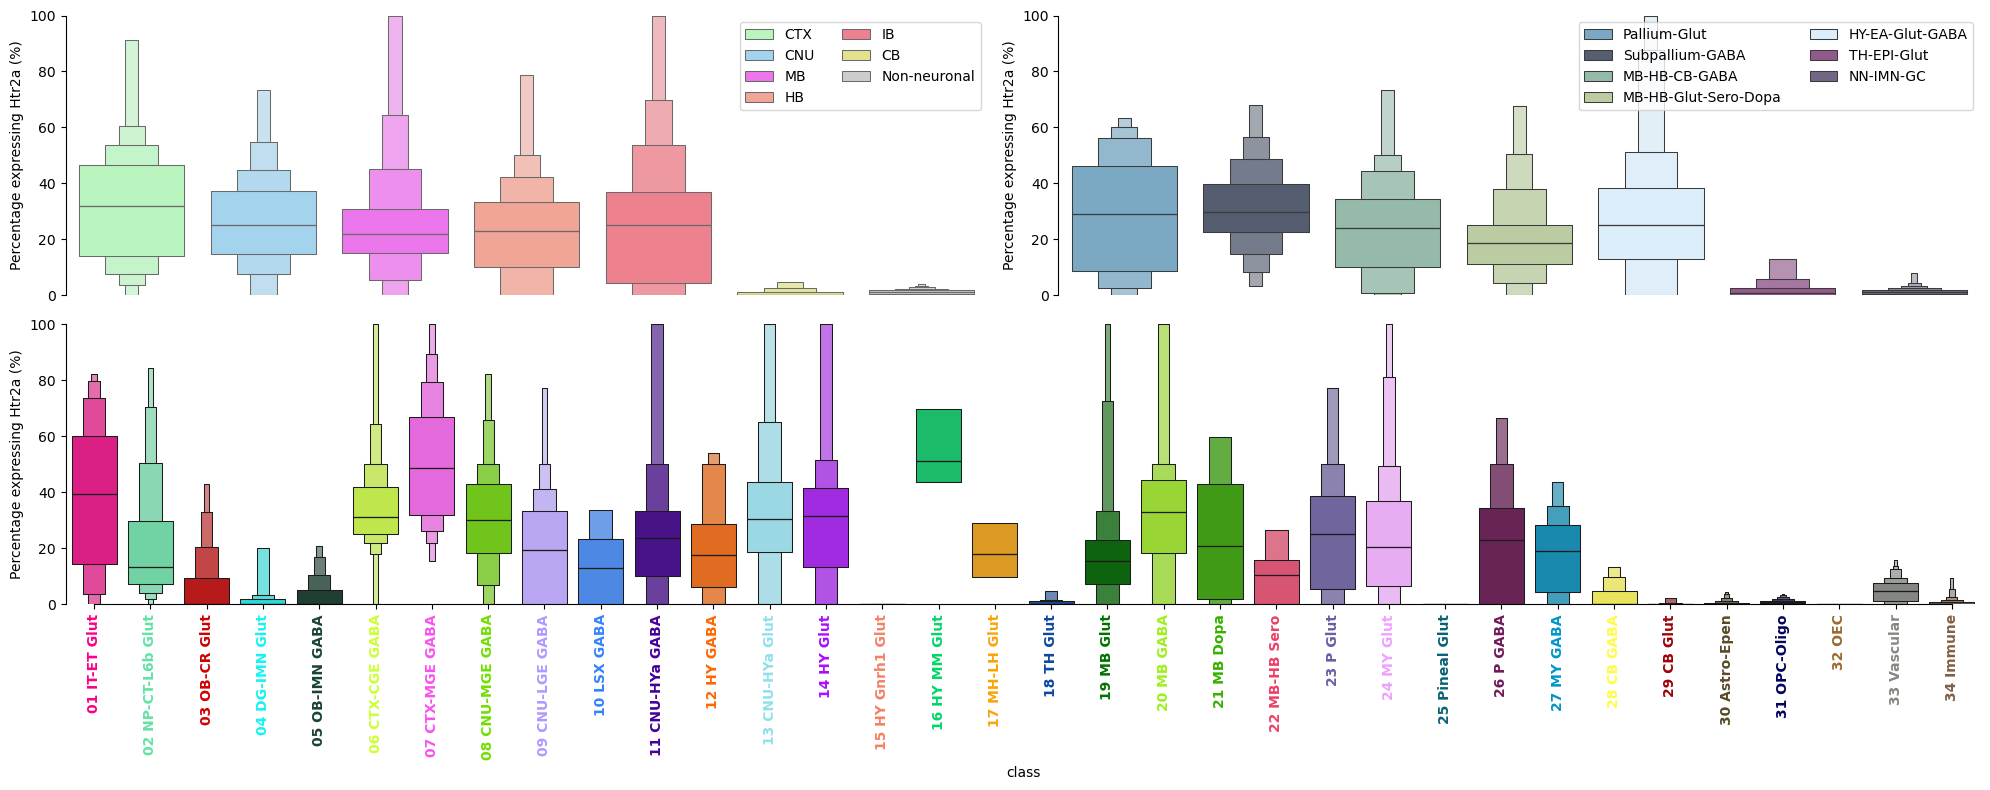

In [870]:
fig = plt.figure(figsize=(20, 8))

gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])  
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2:])

# Plotting for ax0
sns.boxenplot(
    data=joined.groupby(["broad_division", 'donor_label'])[gene].apply(percentage_non_zero).loc[order_broad_division].reset_index(),
y=gene,x="broad_division",showfliers=0,hue= "broad_division",palette=broad_division_color_map,ax=ax0, legend=True)  

data = joined_with_membership.groupby(["cluster_group_name", 'donor_label'])[gene].apply(percentage_non_zero).reset_index()
data = data[data["cluster_group_name"]!="WholeBrain"].reset_index(drop=True)
sns.boxenplot(
    data=data, ax=ax1, x="cluster_group_name", y=gene, hue="cluster_group_name", 
    palette=cluster_groups_cmap, order=[x for x in neuron_cluster_groups_order if x !="WholeBrain"],hue_order=[x for x in neuron_cluster_groups_order if x !="WholeBrain"], showfliers=0, legend=1)

for ax in [ax0, ax1]:
    ax.set_xticks([])  # This will remove the x-axis ticks
    ax.set_xticklabels([])  # This will remove the x-axis labels
    ax.set_xlabel("")  # This will remove the x-axis labels
    sns.despine(ax=ax, bottom=True)
    
# Plotting for ax2
sns.boxenplot(
    data=joined.groupby(["class", 'donor_label'])[gene].apply(percentage_non_zero).reset_index(), 
    y=gene, hue="class",x="class", palette=classification_cmap,
    ax=ax2, showfliers=0)

plt.draw()

for label in ax2.get_xticklabels():
    label.set_rotation(90)
    label.set_color(classification_cmap[label.get_text()])
    label.set_weight('bold')


sns.despine(ax=ax2, trim=True)

for ax in [ax0, ax1, ax2]:
    ax.set_ylim((0,100))
    locations = ax.get_yticks()
    ax.set_yticks(locations)
    ax.set_yticklabels(labels)
    ax.set_ylabel(f'Percentage expressing {gene} (%)')

ax0.legend(ncol=2)
ax1.legend(ncol=2)

plt.tight_layout()

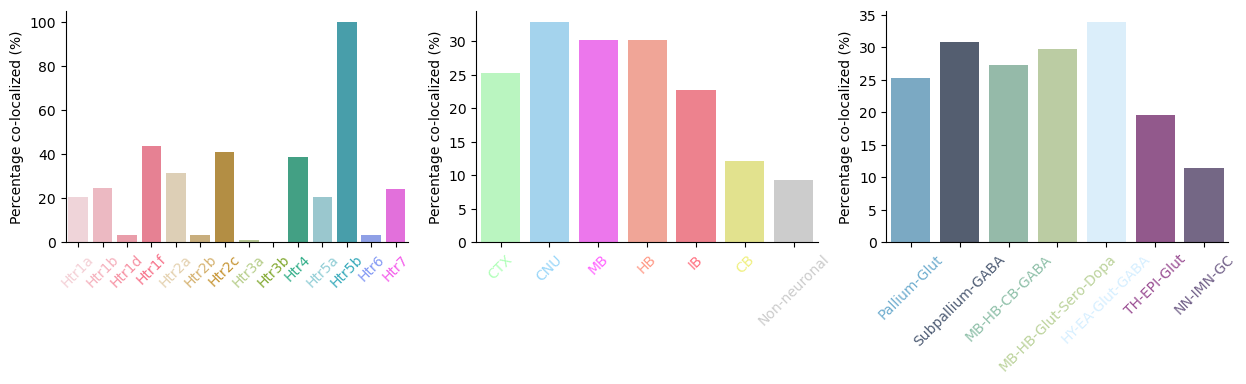

In [794]:
coloc = pd.read_pickle(f"{output_folder_calculations}/cluster_group_colocalization.pkl")

coloc = coloc[coloc["Gene1"]==gene]
coloc["Value"] = coloc["Value"] * 100
fig, axs = plt.subplots(1,3, figsize=(15,3))
# Create the line plot

sns.barplot(
    data=coloc.groupby(["group", "Gene1"])["Value"].mean().reset_index(),
    y="Value", x="group",hue="group", palette=cluster_groups_cmap, ax=axs[2], order = [x for x in neuron_cluster_groups_order if x != "WholeBrain"]
)

axs[2].set_xlabel("")
axs[2].set_ylabel("Percentage co-localized (%)")

axs[2].tick_params(axis='x', rotation=45)

coloc = pd.read_pickle(f"{output_folder_calculations}/broad_division_colocalization.pkl")
coloc = coloc[coloc["Gene1"]==gene]

sns.barplot(
    data=coloc.groupby(["broad_division", "Gene1"])["Value"].mean().reset_index(),
    y="Value", x="broad_division",hue="broad_division", palette=broad_division_color_map, ax=axs[1], order = order_broad_division
)

axs[1].set_xlabel("")
axs[1].set_ylabel("Percentage co-localized (%)")

axs[1].tick_params(axis='x', rotation=45)


coloc = pd.read_pickle(f"{output_folder_calculations}/total_colocalization.pkl")

coloc = coloc[coloc["Gene1"]==gene]
sns.barplot(
    data=coloc,
    y="Value", x="Gene2",hue="Gene2", palette=htr_cmap, ax=axs[0]
)
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_xlabel("")
axs[0].set_ylabel("Percentage co-localized (%)")

plt.draw()

for xtick in axs[0].get_xticklabels():
    xtick.set_color(htr_cmap[xtick.get_text()])

for xtick in axs[1].get_xticklabels():
    xtick.set_color(broad_division_color_map[xtick.get_text()])

for xtick in axs[2].get_xticklabels():
    xtick.set_color(cluster_groups_cmap[xtick.get_text()])
    
sns.despine()

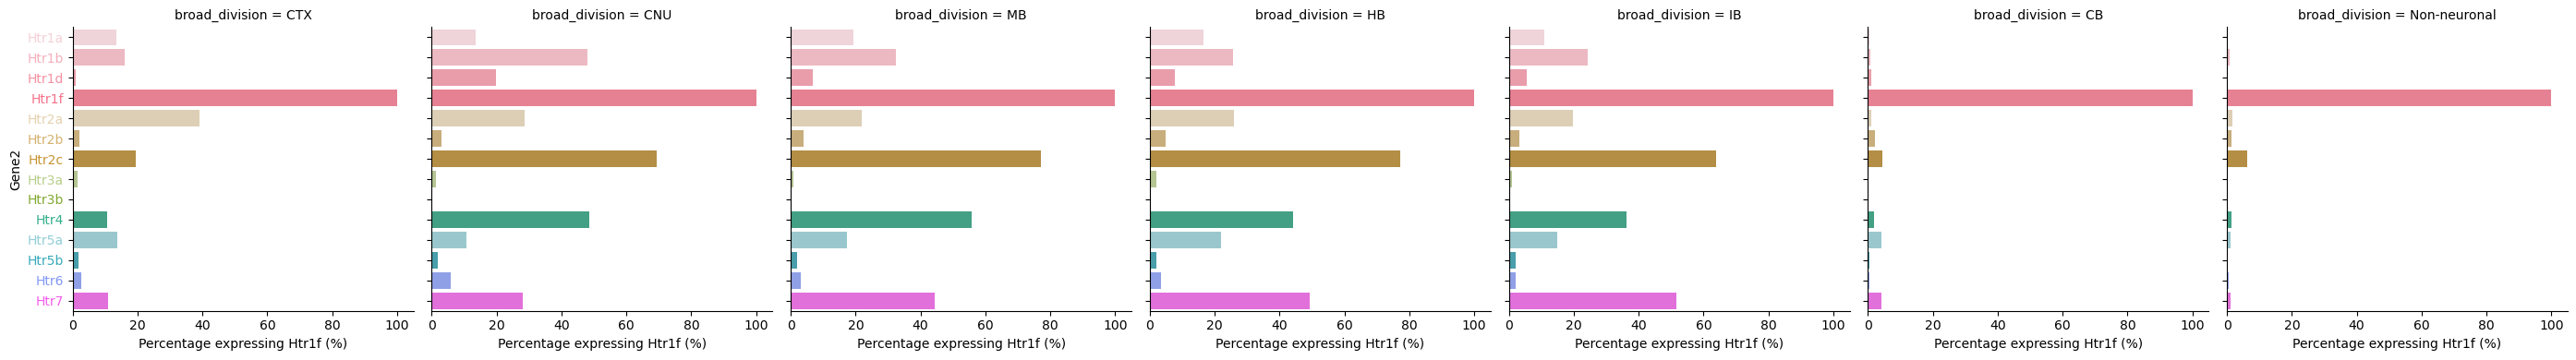

In [759]:
coloc = pd.read_pickle(f"{output_folder_calculations}/broad_division_colocalization.pkl")
coloc = coloc[coloc["Gene1"]==gene]
coloc = coloc.groupby(["broad_division", "Gene2"])["Value"].mean().reset_index()

grid = sns.FacetGrid(coloc, col="broad_division", col_order=order_broad_division,
                     col_wrap=7, height=4)
grid.map(sns.barplot, "Value", "Gene2", "Gene2", order=htrgenes, hue_order=htrgenes, palette=htr_cmap )
for ax in grid.axes.flat:
    ax.set_xlabel(f'Percentage expressing {gene} (%)')
    ax.tick_params(axis='x', rotation=45)
    for ytick in ax.get_yticklabels():
        ytick.set_color(htr_cmap[ytick.get_text()])

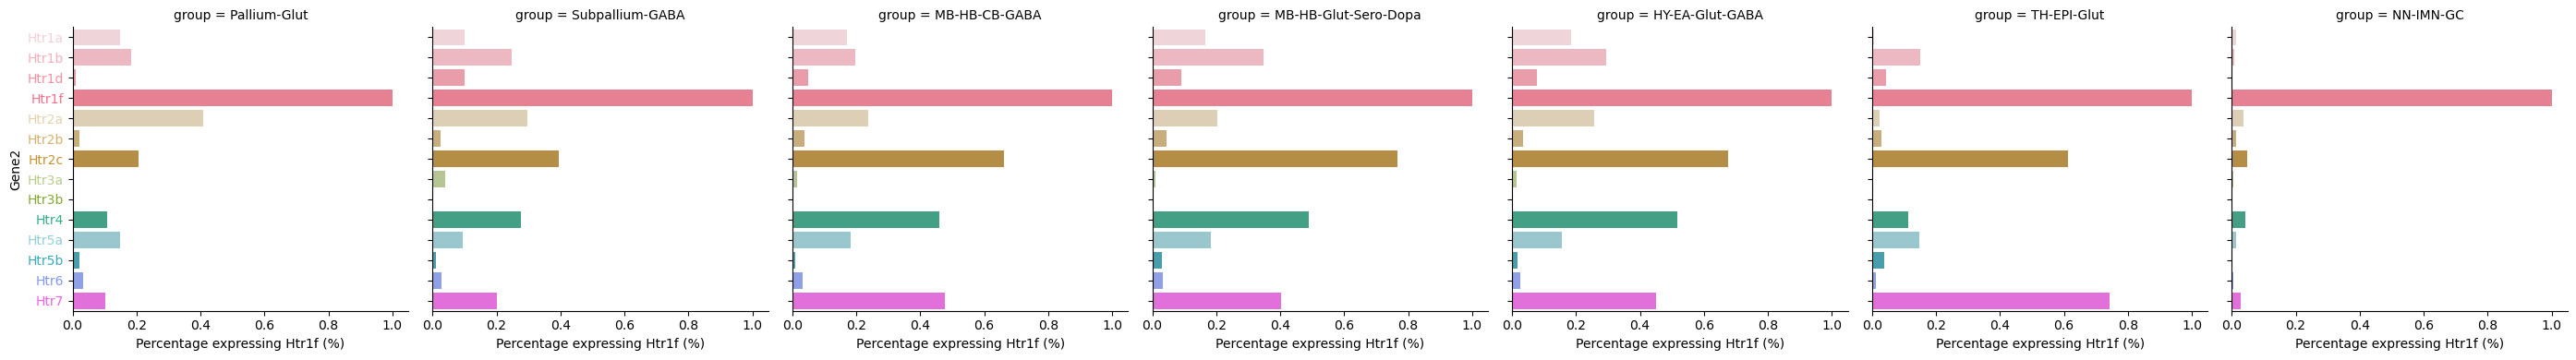

In [761]:
coloc = pd.read_pickle(f"{output_folder_calculations}/cluster_group_colocalization.pkl")
coloc = coloc[coloc["Gene1"]==gene]
coloc = coloc.groupby(["group", "Gene2"])["Value"].mean().reset_index()

grid = sns.FacetGrid(coloc, col="group", col_order=[x for x in neuron_cluster_groups_order if x != "WholeBrain"],
                     col_wrap=7, height=4)
grid.map(sns.barplot, "Value", "Gene2", "Gene2", order=htrgenes, hue_order=htrgenes, palette=htr_cmap )
for ax in grid.axes.flat:
    ax.set_xlabel(f'Percentage expressing {gene} (%)')

    for ytick in ax.get_yticklabels():
        ytick.set_color(htr_cmap[ytick.get_text()])

## spatial expression across coronal slices

In [391]:
import matplotlib.patheffects as path_effects


In [508]:
def plot_class_expression_split_by_categories(subfig,  cls, df_subset, gene):
    axs = subfig.subplots(4,1)
    subfig.subplots_adjust(left=0.05, right=.95)
    
    
    sns.violinplot(data=df_subset, y=f'{gene} prevalence (%)', x='subclass', hue='subclass' ,ax=axs[0], palette= classification_cmap, fill=False)
        
    # Set the title with desired modifications
    title = axs[0].set_title(cls, color=classification_cmap[cls], fontweight='bold', fontsize=20)
    title.set_path_effects([path_effects.withStroke(linewidth=3, foreground='black')])
        
    subfig.set_facecolor(mcolors.to_rgba(classification_cmap[cls], alpha=0.15) )
    
    axs[0].set_ylim(0, 100)  # Set y-axis limit to 1
    axs[0].xaxis.set_ticks_position('top') 
    axs[0].tick_params(axis='x', length=0)
    
    sns.violinplot(data=df_subset, y=f'{gene} prevalence (%)', x='supertype', hue='supertype' ,ax=axs[1], palette= classification_cmap, fill=False)
    axs[1].set_title(cls)
    axs[1].set_ylim(0, 100)  # Set y-axis limit to 1
    
    
    sns.barplot(data=df_subset, y=f'{gene} prevalence (%)', x='cluster',hue='cluster' ,ax=axs[2], palette= classification_cmap)
    axs[2].set_title(cls)
    axs[2].set_ylim(0, 100)  # Set y-axis limit to 1
    
    axs[2].set( ylabel='')
    axs[0].set( ylabel='')
    axs[2].set(xticks=[], xlabel='')
    axs[1].set(xticks=[], xlabel='')
    axs[0].set(xticks=[], xlabel='')
    axs[0].set( xlabel='')
    axs[2].set(xticks=[], xlabel='')
    axs[2].set(xticks=[], xlabel='')
    axs[1].set_title('')
    axs[2].set_title('')
    plt.draw()
    for tick in axs[0].get_xticklabels():
        tick.set_color(classification_cmap[tick.get_text()])
    
    # Identify positions for subclass delimiters in the cluster graph
    subclass_ends = df_subset.groupby('subclass').size().cumsum()
    subclass_positions = subclass_ends - 1
    
    # For the third plot (clusters):
    for pos in subclass_positions[:-1]:
        axs[2].axvline(pos + 0.5, color='gray', linestyle='--')
    
    # For the first plot (subclass), simply draw lines between unique subclasses
    for i in range(1, len(df_subset['subclass'].unique())):
        axs[0].axvline(i - 0.5, color='gray', linestyle='--')
    
    # For the second plot (supertype), the position will be based on unique supertypes per subclass
    supertype_ends = df_subset.groupby('subclass')['supertype'].nunique().cumsum()
    supertype_positions = supertype_ends - 1
    for pos in supertype_positions[:-1]:
        axs[1].axvline(pos + 0.5, color='gray', linestyle='--')
    
    
    # For the first plot (subclass):
    subclasses = df_subset['subclass'].unique()
    start = -.5
    for i, subclass in enumerate(subclasses):
        end = i + 0.5
        color = classification_cmap[subclass]
        axs[0].axvspan(start+.05, end-.05, facecolor=color, alpha=0.15)
        start = end
    
    
    # For the second plot (supertype), determine filling areas based on unique supertypes per subclass
    supertype_ends = df_subset.groupby('subclass')['supertype'].nunique().cumsum()
    supertype_positions = supertype_ends - 1
    
    previous_position = -0.5  # initialize to start from the first entry
    for idx, pos in enumerate(supertype_positions):
        current_position = pos + 0.5
        # Retrieve the subclass name for the current supertype
        subclass_name = df_subset['subclass'].unique()[idx]
        color = classification_cmap[subclass_name]
        
        axs[1].axvspan(previous_position + 0.2, current_position -.2, facecolor=color, alpha=0.15)
    
        previous_position = current_position  # set for the next iteration
    
    ####third plot filling
    # Get a mapping of subclasses to their dominant cluster
    subclass_to_cluster = df_subset.groupby('subclass')['cluster'].apply(lambda x: x.value_counts().idxmax())
    
    # Define previous position to help us fill areas between borders
    prev_pos = 0
    
    # Iterate over the subclass positions and the corresponding subclasses
    for idx, (subclass, cluster) in enumerate(subclass_to_cluster.items()):
        # Get the color for this subclass's dominant cluster from your cmap
        color_value = classification_cmap[cluster]
        
        # End position is either the next border position or the end of the plot
        end_pos = subclass_positions[idx] if idx < len(subclass_positions) else len(df_subset['cluster']) - 1
        
        # Fill the area with the given color
        axs[2].fill_between([prev_pos, end_pos], 0, 100, color=color_value, alpha=0.15)
        
        # Update the previous position to the current position
        prev_pos = end_pos + 1
    
    # Adjust the xlim of each axis
    axs[0].set_xlim(-0.5, len(df_subset['subclass'].unique()) - 0.5)
    axs[1].set_xlim(-0.5, len(df_subset['supertype'].unique()) - 0.5)
    axs[2].set_xlim(-.8, len(df_subset['cluster'].unique()))

    # Now, add legend in the fourth axis:
    patches = [plt.Line2D([0], [0], color=classification_cmap[c], lw=8) for c in df_subset["subclass"].unique()]
    labels = list(df_subset["subclass"].unique())
    
    axs[3].legend(patches, labels, loc='center', ncol=8, handlelength=1.8, handleheight=1)
    axs[3].axis('off')  # Hide axis

    sns.despine(bottom=True)  



Plotting:   0%|          | 0/7 [00:00<?, ?it/s]

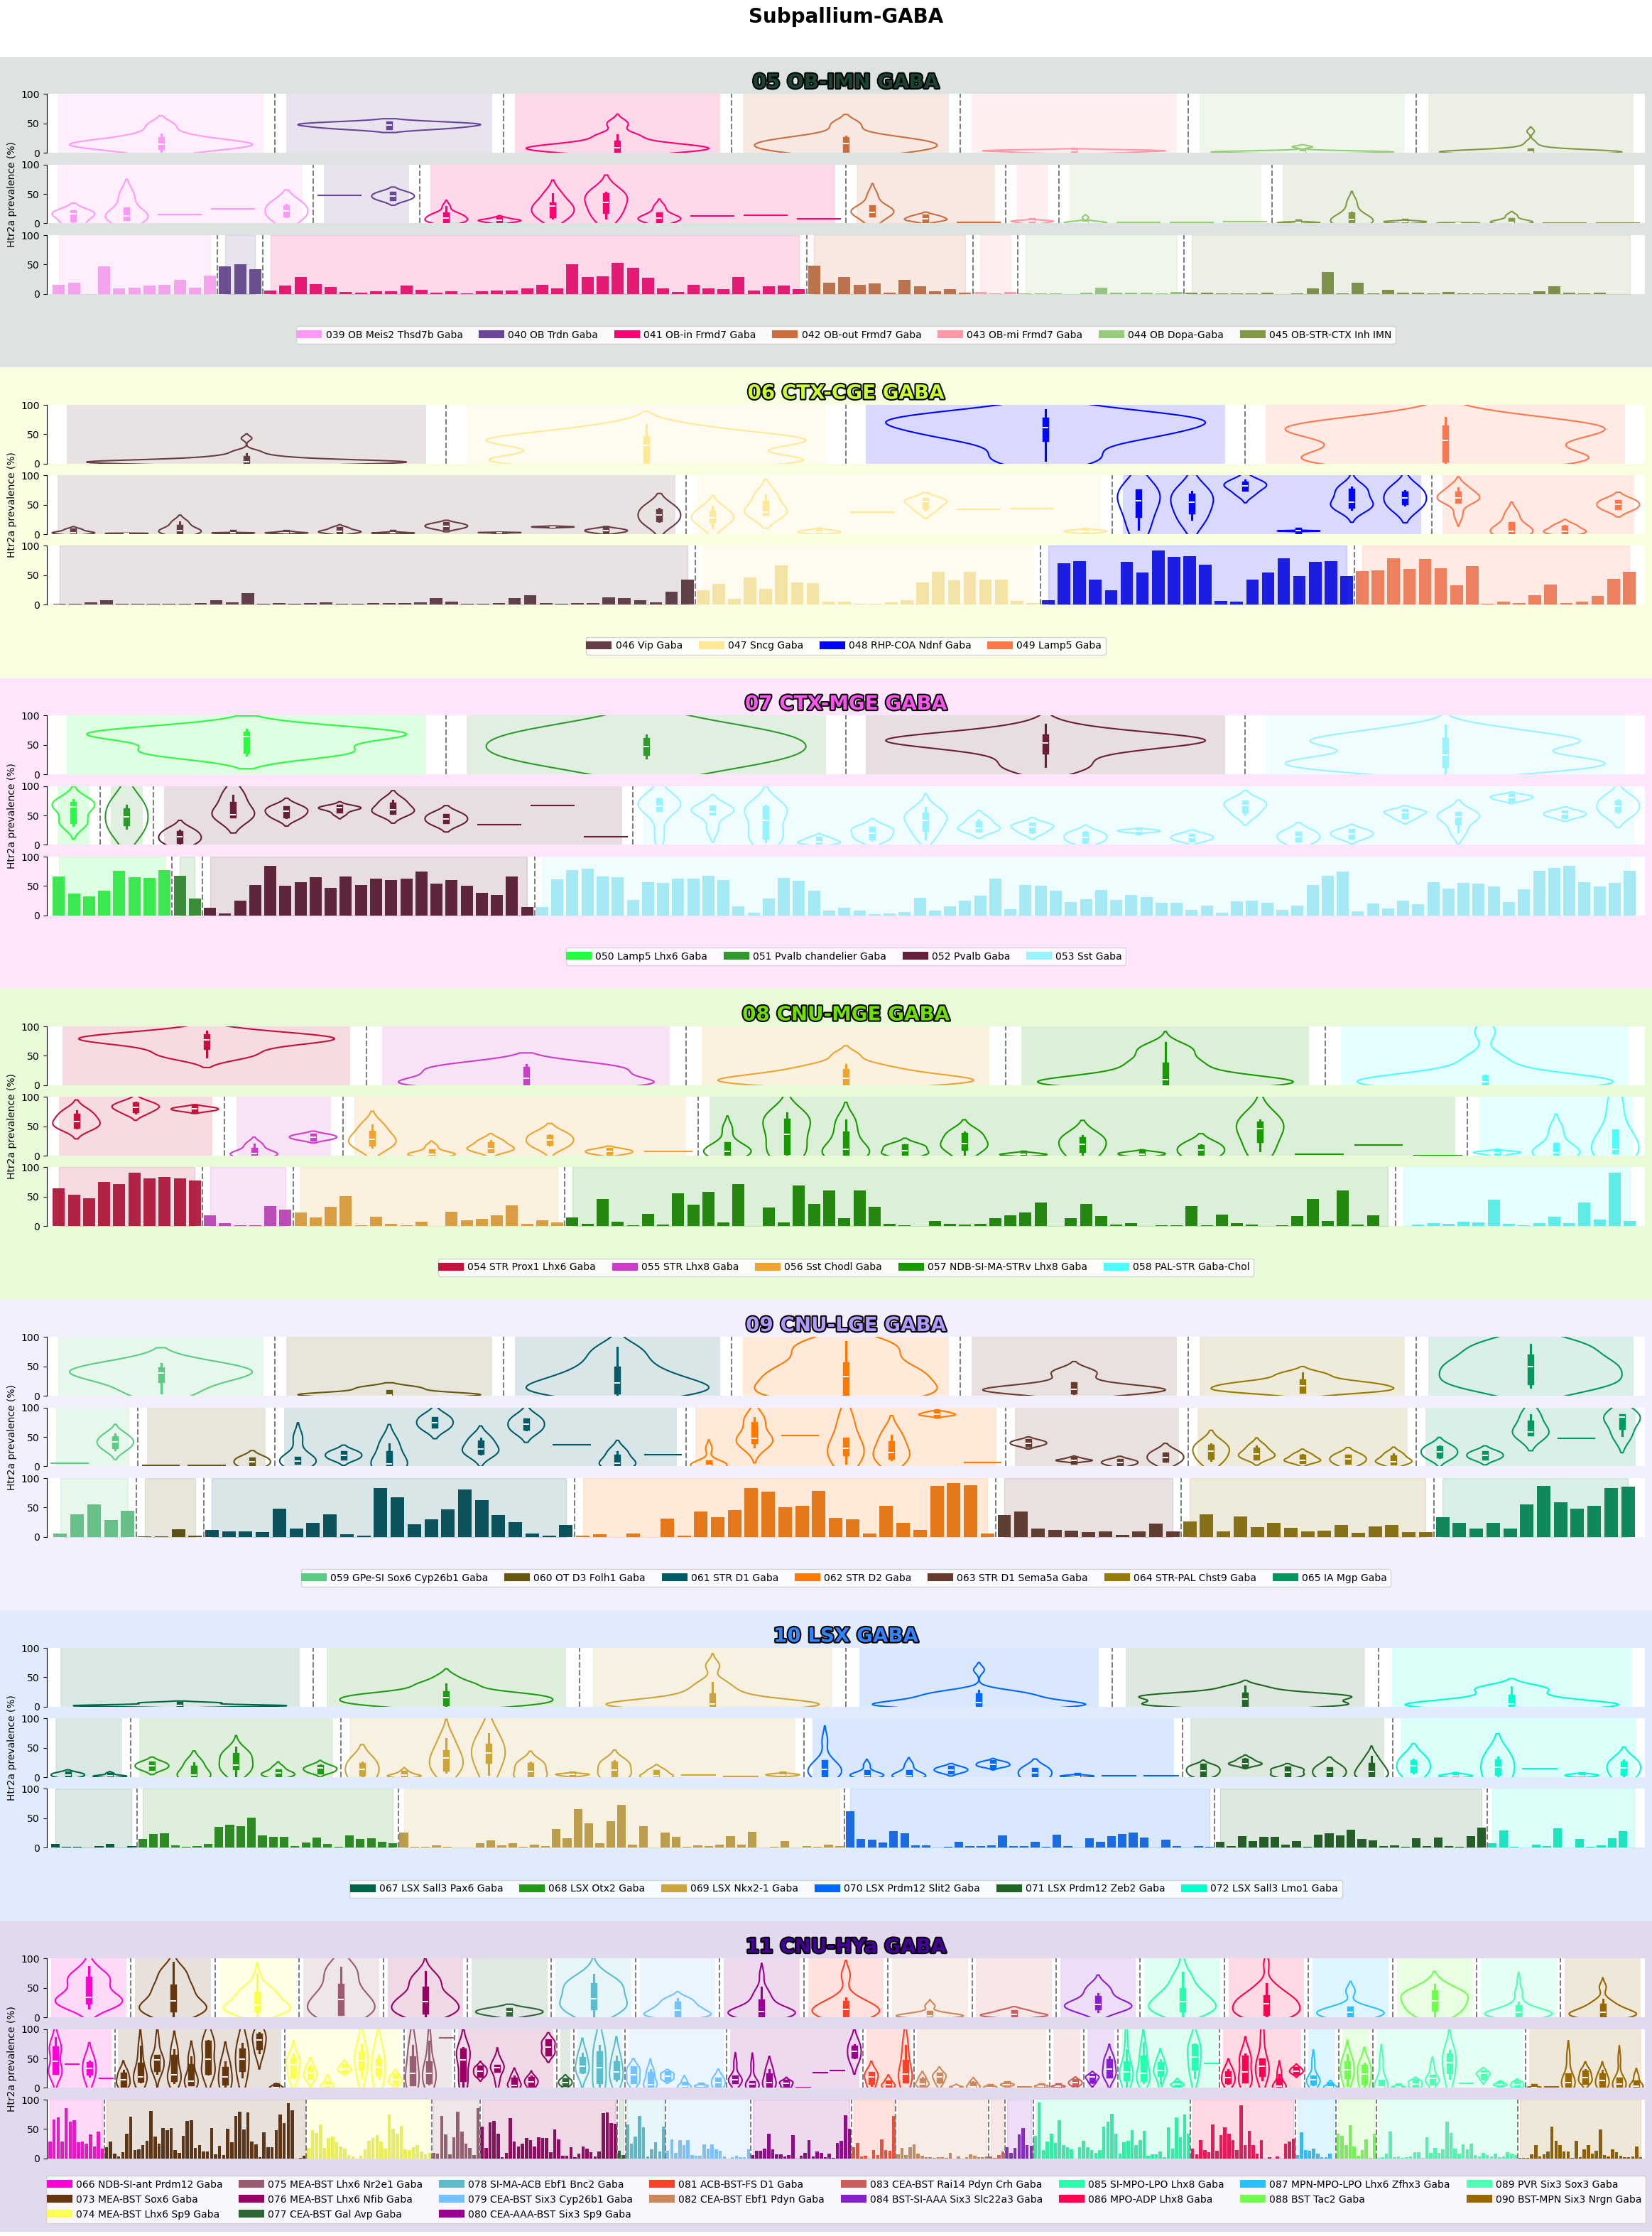

In [825]:
group = [x for x in neuron_cluster_groups_order if x !="WholeBrain"][1]
data = joined_with_membership[joined_with_membership["cluster_group_name"]==group]
data = data.groupby(["cluster_group_name","class","subclass", "supertype", "cluster"])[gene].apply(percentage_non_zero).reset_index()
data = data[data["cluster_group_name"]!="WholeBrain"]
data["cluster_group_name"] = pd.Categorical(data["cluster_group_name"], categories=neuron_cluster_groups_order, ordered=True)
data = data.sort_values(by=["cluster_group_name", "class"])

data[gene] = data[gene] *100
data.rename(columns={gene: f'{gene} prevalence (%)'}, inplace=True)

fig = plt.figure(figsize=(25, 5*data['class'].nunique()))

gs = gridspec.GridSpec(data['class'].nunique()+1, 1)


for n, cls in tqdm(enumerate(data['class'].unique()), total=len(data['class'].unique()), desc="Plotting"):
    df_subset = data[data['class'] == cls]
    subfig = fig.add_subfigure(gs[n,:])   
    subfig.subplots_adjust(left=0.05, right=.95, bottom=0.01)
    plot_class_expression_split_by_categories(subfig, cls, df_subset, gene)

fig.suptitle(group, y=1.02, fontweight='bold', fontsize=20);

# Interactive selection Htrs and neuron groups

In [506]:
import ipywidgets as widgets
from ipywidgets import interactive
from ipywidgets import HBox

In [507]:
def interactive_plot(group, gene):
    
    data = joined_with_membership[joined_with_membership["cluster_group_name"]==group]
    data = data.groupby(["cluster_group_name","class","subclass", "supertype", "cluster"])[gene].apply(percentage_non_zero).reset_index()
    data = data[data["cluster_group_name"]!="WholeBrain"]
    data["cluster_group_name"] = pd.Categorical(data["cluster_group_name"], categories=neuron_cluster_groups_order, ordered=True)
    data = data.sort_values(by=["cluster_group_name", "class"])

    data[gene]=data[gene] *100
    data.rename(columns={gene: f'{gene} prevalence (%)'}, inplace=True)

    fig = plt.figure(figsize=(20, 4*data['class'].nunique()))
    fig.suptitle(group, fontsize=16)
    gs = gridspec.GridSpec(data['class'].nunique(), 1)

    
    for n, cls in tqdm(enumerate(data['class'].unique()), total=len(data['class'].unique()), desc="Plotting"):
        df_subset = data[data['class'] == cls]
        subfig = fig.add_subfigure(gs[n,:])   
        subfig.subplots_adjust(left=0.05, right=.95, bottom=0.01)
        plot_class_expression_split_by_categories(subfig, cls, df_subset, gene)
    
    fig.suptitle(group, y=1.02, fontweight='bold', fontsize=20);


# Using interact with both gene and group dropdowns

widget1 = widgets.Dropdown(
    options=[x for x in neuron_cluster_groups_order if x != "WholeBrain"],
    value=[x for x in neuron_cluster_groups_order if x != "WholeBrain"][0],
    description='Group:'
)

widget2 = widgets.Dropdown(
    options=htrgenes,
    value='Htr1a',
    description='Gene:'
)

w = interactive(interactive_plot, group=widget1, gene=widget2)

# Display the controls in a row
display(HBox(w.children[:-1]))

# Display the output below the controls
display(w.children[-1])

Output()

In [833]:
data[(data[f"{gene} prevalence (%)"]>60) & (data["subclass"]=="053 Sst Gaba")].sort_values(f"{gene} prevalence (%)", ascending=False)

cluster_group_name            class      subclass         supertype  \
306    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba  0230 Sst Gaba_17   
305    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba  0230 Sst Gaba_17   
241    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba   0214 Sst Gaba_1   
240    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba   0214 Sst Gaba_1   
310    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba  0232 Sst Gaba_19   
304    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba  0230 Sst Gaba_17   
291    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba  0225 Sst Gaba_12   
290    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba  0225 Sst Gaba_12   
249    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba   0216 Sst Gaba_3   
242    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba   0214 Sst Gaba_1   
243    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba   0214 Sst Gaba_1   
254    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba   0216 Sst Gaba_3   
248    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba   0215 Sst Gaba_2   
268    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba   0219 Sst Gaba_6   
247    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba   0215 Sst Gaba_2   
239    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba   0214 Sst Gaba_1   
250    Subpallium-GABA  07 CTX-MGE GABA  053 Sst Gaba   0216 Sst Gaba_3   

              cluster  Htr2a prevalence (%)  
306  0824 Sst Gaba_17             83.823529  
305  0823 Sst Gaba_17             80.755396  
241   0759 Sst Gaba_1             79.358717  
240   0758 Sst Gaba_1             76.715040  
310  0828 Sst Gaba_19             76.250000  
304  0822 Sst Gaba_17             76.136364  
291  0809 Sst Gaba_12             74.230769  
290  0808 Sst Gaba_12             67.536232  
249   0767 Sst Gaba_3             67.307692  
242   0760 Sst Gaba_1             65.555556  
243   0761 Sst Gaba_1             65.483384  
254   0772 Sst Gaba_3             64.210526  
248   0766 Sst Gaba_2             62.962963  
268   0786 Sst Gaba_6             62.878788  
247   0765 Sst Gaba_2             62.385321  
239   0757 Sst Gaba_1             60.878661  
250   0768 Sst Gaba_3             60.606061